# Flower Quickstart (Simulation with TensorFlow/Keras)

Welcome to Flower, a friendly federated learning framework!

In this notebook, we'll simulate a federated learning system with 100 clients. The clients will use TensorFlow/Keras to define model training and evaluation. Let's start by installing Flower (published as `flwr` on PyPI) with the `simulation` extra:

In [ ]:
pip install ray

/bin/bash: /home/s5/anaconda3/envs/tf/lib/libtinfo.so.6: no version information available (required by /bin/bash)
Note: you may need to restart the kernel to use updated packages.


In [ ]:
pip install tensorflow

In [ ]:
pip install flwr    

In [ ]:
pip install pandas

In [ ]:
pip install matplotlib

In [ ]:
pip install tdqm

In [ ]:
pip install seaborn

In [ ]:
pip install numpy

In [ ]:
pip install sklearn

In [ ]:
pip install imblearn

Let's also install Matplotlib so we can make some plots once the simulation is completed

In [ ]:
import math
from typing import Dict, List, Tuple

import tensorflow as tf

import flwr as fl
from flwr.common import Metrics
from flwr.simulation.ray_transport.utils import enable_tf_gpu_growth
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Conv1D, Flatten, Dense
from sklearn.metrics import precision_score, recall_score, f1_score, precision_recall_fscore_support
import time
import numpy as np
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from tensorflow.config.experimental import list_physical_devices, set_memory_growth




2023-09-25 17:49:30.892795: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-25 17:49:31.005422: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-09-25 17:49:31.031502: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-09-25 17:49:31.539568: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

In [ ]:
def get_model():
    """Constructs a simple model architecture suitable for Attack Classification."""
    model = keras.Sequential(
        [
            keras.layers.Input(shape=(59, 1)),  # Input layer with 42 features
            keras.layers.Conv1D(16, kernel_size=3, padding='same', activation='relu'),  # 1D CNN hidden layer
            keras.layers.LSTM(32),  # LSTM layer
            keras.layers.Dense(32, activation='relu'),             
            keras.layers.Dense(8, activation='softmax')  # Output layer with 8 classes
        ]
    )
    model.compile(
        optimizer="adam", 
        loss="sparse_categorical_crossentropy", 
        metrics=["accuracy", "precision", "recall", "auc"]
    )
    return model


In [ ]:
class FlowerClient(fl.client.NumPyClient):
    def __init__(self, x_train, y_train, x_val, y_val, cid) -> None:
        # Create model
        self.cid = cid
        self.model = get_model()
        self.x_train, self.y_train = x_train, y_train
        self.x_val, self.y_val = x_val, y_val

    def get_parameters(self, config):
        return self.model.get_weights()

    def fit(self, parameters, config):
        self.model.set_weights(parameters)
        
        unique_classes, _ = tf.unique(self.y_train)
        # Get the total number of unique classes
        total_classes = tf.shape(unique_classes)[0]
        
        print("TotalClass of ", self.cid , " : ", total_classes.numpy())
        self.model.fit(
            self.x_train, self.y_train, epochs=1, batch_size=32, verbose=VERBOSE
        )
        return self.model.get_weights(), len(self.x_train), {}

    def evaluate(self, parameters, config):
    self.model.set_weights(parameters)
    results = self.model.evaluate(
        self.x_val, self.y_val, batch_size=32, verbose=VERBOSE
    )
    loss, acc, precision, recall, auc = results
    return loss, len(self.x_val), {"accuracy": acc, "precision": precision, "recall": recall, "auc": auc}

In [ ]:
pip install pandas pyarrow

In [ ]:
def get_client_fn(dataset_partitions):
    """Return a function to be executed by the VirtualClientEngine in order to construct
    a client."""

    def client_fn(cid: str) -> fl.client.Client:
        """Construct a FlowerClient with its own dataset partition."""

        # Extract partition for client with id = cid
        x_train, y_train = dataset_partitions[int(cid)]
        # Use 10% of the client's training data for validation
        split_idx = math.floor(len(x_train) * 0.9)
        x_train_cid, y_train_cid = (
            x_train[:split_idx],
            y_train[:split_idx],
        )
        x_val_cid, y_val_cid = x_train[split_idx:], y_train[split_idx:]

        # Create and return client
        return FlowerClient(x_train_cid, y_train_cid, x_val_cid, y_val_cid, cid)

    return client_fn


def partition_attacks():
    """Download and partitions the dataset."""
    df = pd.read_parquet('cic-collection.parquet')
    x = data.drop(['Label', 'ClassLabel'], axis=1)
    y = data['ClassLabel']

    # Create a mapping between class names and numeric labels
    class_mapping = {
      'Benign': 0,
      'DDoS': 1,
      'DoS': 2,
      'Botnet' : 3,
      'Bruteforce': 4,
      'Infiltration' : 5,
      'Webattack' : 6,
      'Portscan' : 7

      }

    # Map class names to numeric labels in y
    y_mapped = y.map(class_mapping)


    # Split the dataset into training and testing sets
    x_train, x_test, y_train_mapped, y_test_mapped = train_test_split(x, y_mapped, test_size=0.2, random_state=42)
    partitions = []

    # Calculate the size of each partition
    partition_size = math.floor(len(x_train) / NUM_CLIENTS)

    # Iterate through clients and create partitions
    for cid in range(NUM_CLIENTS):
        idx_from, idx_to = int(cid) * partition_size, (int(cid) + 1) * partition_size
        
        client_x = x_train[idx_from:idx_to]  # Features for the client
        client_y = y_train_mapped[idx_from:idx_to]  # Labels for the client
        partitions.append((client_x, client_y))

    # Assign the testset
    testset = (x_test, y_test_mapped)

    return partitions, testset


def weighted_average(metrics: List[Tuple[int, Metrics]]) -> Metrics:
    """Aggregation function for (federated) evaluation metrics, i.e. those returned by
    the client's evaluate() method."""
    # Multiply accuracy of each client by number of examples used
    accuracies = [num_examples * m["accuracy"] for num_examples, m in metrics]
    examples = [num_examples for num_examples, _ in metrics]

    # Aggregate and return custom metric (weighted average)
    return {"accuracy": sum(accuracies) / sum(examples)}


def get_evaluate_fn(testset):
    """Return an evaluation function for server-side (i.e. centralized) evaluation."""
    x_test, y_test = testset

    # The `evaluate` function will be called after every round by the strategy
    def evaluate(
        server_round: int,
        parameters: fl.common.NDArrays,
        config: Dict[str, fl.common.Scalar],
    ):
        model = get_model()  # Construct the model
        model.set_weights(parameters)  # Update model with the latest parameters
        tStart = time.time()
        loss, accuracy = model.evaluate(x_test, y_test, verbose=VERBOSE)
        evalTime = (time.time() - tStart) * 1000

        y_pred = np.argmax(model.predict(x_test), axis=-1)
        # y_val_conv = np.argmax(y_test, axis=1)
#         results = precision_recall_fscore_support(y_test, y_pred, average="micro")
#         precision = results[0]
#         recall = results[1]
#         fscore = results[2]
#         print("MICRO // precision: ", precision)
#         print("recall: ", recall)
        
        
                
        results = precision_recall_fscore_support(y_test, y_pred, average="weighted", labels=np.unique(y_pred))
        precision = results[0]
        recall = results[1]
        fscore = results[2]
        print("weighted // precision: ", precision)
        print("recall: ", recall)
        
#         results = precision_recall_fscore_support(y_test, y_pred, average="macro")
#         precision = results[0]
#         recall = results[1]
#         fscore = results[2]
#         print("MACRO // precision: ", precision)
#         print("recall: ", recall)
        
        

        # return loss, {"accuracy": accuracy, "evalTime": evalTime}
        return loss, {
            "accuracy": accuracy,
            "evalTime": evalTime,
            "precision": precision,
            "recall": recall,
            "fscore": fscore,
        }

    return evaluate

In [19]:
VERBOSE = 0
NUM_CLIENTS = 14

In [20]:

# Create dataset partitions (needed if your dataset is not pre-partitioned)
partitions, testset = partition_attacks()


/tmp/ipykernel_3821805/3306612760.py:57: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  client_y = y_train_mapped[idx_from:idx_to]  # Labels for the client


In [10]:
enable_tf_gpu_growth()


In [23]:


#Create FedAvg strategy
strategy = fl.server.strategy.FedAvg(
    fraction_fit=1,  # Sample 90% of available clients for training
    fraction_evaluate=0.5,  # Sample 10% of available clients for evaluation
    min_fit_clients=NUM_CLIENTS,  # Never sample less than 5 clients for training
    min_evaluate_clients=NUM_CLIENTS,  # Never sample less than 5 clients for evaluation
    min_available_clients= NUM_CLIENTS, # Wait until at least 5 clients are available
    evaluate_metrics_aggregation_fn=weighted_average,  # aggregates federated metrics
    evaluate_fn=get_evaluate_fn(testset),  # global evaluation function
)

# With a dictionary, you tell Flower's VirtualClientEngine that each
# client needs exclusive access to these many resources in order to run
client_resources = {"num_cpus": 1, "num_gpus": 0.0}

# Start simulation
history = fl.simulation.start_simulation(
    client_fn=get_client_fn(partitions),
    num_clients=NUM_CLIENTS,
    config=fl.server.ServerConfig(num_rounds=100,round_timeout=600.0),
    strategy=strategy,
    client_resources=client_resources,
    actor_kwargs={
        "on_actor_init_fn": enable_tf_gpu_growth  # Enable GPU growth upon actor init.
    },
)

INFO flwr 2023-09-25 23:53:11,099 | app.py:175 | Starting Flower simulation, config: ServerConfig(num_rounds=100, round_timeout=600.0)
2023-09-25 23:53:18,421	INFO worker.py:1621 -- Started a local Ray instance.
INFO flwr 2023-09-25 23:53:19,485 | app.py:210 | Flower VCE: Ray initialized with resources: {'GPU': 3.0, 'accelerator_type:G': 1.0, 'object_store_memory': 19781318246.0, 'node:202.31.134.217': 1.0, 'memory': 39562636494.0, 'node:__internal_head__': 1.0, 'CPU': 28.0}
INFO flwr 2023-09-25 23:53:19,486 | app.py:224 | Flower VCE: Resources for each Virtual Client: {'num_cpus': 10, 'num_gpus': 0.0}
INFO flwr 2023-09-25 23:53:19,499 | app.py:270 | Flower VCE: Creating VirtualClientEngineActorPool with 2 actors
INFO flwr 2023-09-25 23:53:19,500 | server.py:89 | Initializing global parameters
INFO flwr 2023-09-25 23:53:19,501 | server.py:276 | Requesting initial parameters from one random client
(pid=3937228) 2023-09-25 23:53:20.202156: I tensorflow/core/platform/cpu_feature_guard.cc:

3619/3619 [==============================] - 15s 4ms/step


INFO flwr 2023-09-25 23:53:57,283 | server.py:94 | initial parameters (loss, other metrics): 1.731258511543274, {'accuracy': 0.37153345346450806, 'evalTime': 17787.944078445435, 'precision': 0.7831287451360176, 'recall': 0.38042766939634587, 'fscore': 0.5065666311071771}
INFO flwr 2023-09-25 23:53:57,285 | server.py:104 | FL starting
DEBUG flwr 2023-09-25 23:53:57,285 | server.py:222 | fit_round 1: strategy sampled 14 clients (out of 14)


weighted // precision:  0.7831287451360176
recall:  0.38042766939634587


(DefaultActor pid=3937229) /tmp/ipykernel_3821805/3306612760.py:14: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
(DefaultActor pid=3937229) /tmp/ipykernel_3821805/3306612760.py:16: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
(DefaultActor pid=3937229) 2023-09-25 23:53:22.728183: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical opera

(DefaultActor pid=3937229) TotalClass of  10  :  7


(DefaultActor pid=3937228) 2023-09-25 23:53:58.007919: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
(DefaultActor pid=3937228) To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
(DefaultActor pid=3937229) /tmp/ipykernel_3821805/3306612760.py:16: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`. [repeated 2x across cluster]


(DefaultActor pid=3937229) TotalClass of  7  :  7 [repeated 2x across cluster]


(DefaultActor pid=3937229) /tmp/ipykernel_3821805/3306612760.py:16: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`. [repeated 4x across cluster]


(DefaultActor pid=3937229) TotalClass of  0  :  7 [repeated 2x across cluster]


(DefaultActor pid=3937228) /tmp/ipykernel_3821805/3306612760.py:16: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`. [repeated 4x across cluster]


(DefaultActor pid=3937228) TotalClass of  12  :  7 [repeated 2x across cluster]


(DefaultActor pid=3937229) /tmp/ipykernel_3821805/3306612760.py:16: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`. [repeated 4x across cluster]


(DefaultActor pid=3937229) TotalClass of  4  :  7 [repeated 2x across cluster]


(DefaultActor pid=3937229) /tmp/ipykernel_3821805/3306612760.py:16: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`. [repeated 4x across cluster]


(DefaultActor pid=3937229) TotalClass of  1  :  7 [repeated 2x across cluster]


(DefaultActor pid=3937229) /tmp/ipykernel_3821805/3306612760.py:16: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`. [repeated 4x across cluster]


(DefaultActor pid=3937229) TotalClass of  6  :  7 [repeated 2x across cluster]


DEBUG flwr 2023-09-25 23:57:27,404 | server.py:236 | fit_round 1 received 14 results and 0 failures
WARNING flwr 2023-09-25 23:57:27,453 | fedavg.py:242 | No fit_metrics_aggregation_fn provided


3619/3619 [==============================] - 17s 5ms/step


INFO flwr 2023-09-25 23:58:04,721 | server.py:125 | fit progress: (1, 0.5139027237892151, {'accuracy': 0.8837414383888245, 'evalTime': 18870.4993724823, 'precision': 0.836515141710251, 'recall': 0.9175312273024812, 'fscore': 0.8642126859341279}, 247.43602884188294)
DEBUG flwr 2023-09-25 23:58:04,723 | server.py:173 | evaluate_round 1: strategy sampled 14 clients (out of 14)


weighted // precision:  0.836515141710251
recall:  0.9175312273024812


(DefaultActor pid=3937228) /tmp/ipykernel_3821805/3306612760.py:16: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`. [repeated 4x across cluster]
(DefaultActor pid=3937229) /tmp/ipykernel_3821805/3306612760.py:16: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`. [repeated 10x across cluster]
(DefaultActor pid=3937228) /tmp/ipykernel_3821805/3306612760.py:16: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as 

(DefaultActor pid=3937229) TotalClass of  2  :  7 [repeated 2x across cluster]


(DefaultActor pid=3937229) /tmp/ipykernel_3821805/3306612760.py:16: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`. [repeated 4x across cluster]


(DefaultActor pid=3937229) TotalClass of  0  :  7 [repeated 2x across cluster]


(DefaultActor pid=3937229) /tmp/ipykernel_3821805/3306612760.py:16: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`. [repeated 4x across cluster]


(DefaultActor pid=3937229) TotalClass of  5  :  7 [repeated 2x across cluster]


(DefaultActor pid=3937229) /tmp/ipykernel_3821805/3306612760.py:16: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`. [repeated 4x across cluster]


(DefaultActor pid=3937229) TotalClass of  7  :  7 [repeated 2x across cluster]


(DefaultActor pid=3937229) /tmp/ipykernel_3821805/3306612760.py:16: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`. [repeated 4x across cluster]


(DefaultActor pid=3937229) TotalClass of  13  :  7 [repeated 2x across cluster]


(DefaultActor pid=3937228) /tmp/ipykernel_3821805/3306612760.py:16: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`. [repeated 4x across cluster]


(DefaultActor pid=3937228) TotalClass of  10  :  7 [repeated 2x across cluster]


(DefaultActor pid=3937228) /tmp/ipykernel_3821805/3306612760.py:16: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`. [repeated 4x across cluster]


(DefaultActor pid=3937228) TotalClass of  8  :  7 [repeated 2x across cluster]


DEBUG flwr 2023-09-26 00:01:38,626 | server.py:236 | fit_round 2 received 14 results and 0 failures


3619/3619 [==============================] - 16s 4ms/step


INFO flwr 2023-09-26 00:02:15,415 | server.py:125 | fit progress: (2, 0.40476498007774353, {'accuracy': 0.8952368497848511, 'evalTime': 18906.96930885315, 'precision': 0.8663261973753869, 'recall': 0.9074395069510103, 'fscore': 0.8738189957923423}, 498.1297829328105)
DEBUG flwr 2023-09-26 00:02:15,416 | server.py:173 | evaluate_round 2: strategy sampled 14 clients (out of 14)


weighted // precision:  0.8663261973753869
recall:  0.9074395069510103


(DefaultActor pid=3937229) /tmp/ipykernel_3821805/3306612760.py:16: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`. [repeated 4x across cluster]
(DefaultActor pid=3937228) /tmp/ipykernel_3821805/3306612760.py:16: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`. [repeated 10x across cluster]
(DefaultActor pid=3937229) /tmp/ipykernel_3821805/3306612760.py:16: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as 

(DefaultActor pid=3937228) TotalClass of  12  :  7 [repeated 2x across cluster]


(DefaultActor pid=3937228) /tmp/ipykernel_3821805/3306612760.py:16: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`. [repeated 4x across cluster]


(DefaultActor pid=3937228) TotalClass of  10  :  7 [repeated 2x across cluster]


(DefaultActor pid=3937228) /tmp/ipykernel_3821805/3306612760.py:16: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`. [repeated 4x across cluster]


(DefaultActor pid=3937228) TotalClass of  6  :  7 [repeated 2x across cluster]


(DefaultActor pid=3937228) /tmp/ipykernel_3821805/3306612760.py:16: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`. [repeated 4x across cluster]


(DefaultActor pid=3937228) TotalClass of  11  :  7 [repeated 2x across cluster]


(DefaultActor pid=3937228) /tmp/ipykernel_3821805/3306612760.py:16: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`. [repeated 4x across cluster]


(DefaultActor pid=3937228) TotalClass of  1  :  7 [repeated 2x across cluster]


(DefaultActor pid=3937229) /tmp/ipykernel_3821805/3306612760.py:16: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`. [repeated 4x across cluster]


(DefaultActor pid=3937229) TotalClass of  8  :  7 [repeated 2x across cluster]


(DefaultActor pid=3937229) /tmp/ipykernel_3821805/3306612760.py:16: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`. [repeated 4x across cluster]


(DefaultActor pid=3937229) TotalClass of  5  :  7 [repeated 2x across cluster]


DEBUG flwr 2023-09-26 00:05:53,963 | server.py:236 | fit_round 3 received 14 results and 0 failures


3619/3619 [==============================] - 16s 4ms/step


INFO flwr 2023-09-26 00:06:30,902 | server.py:125 | fit progress: (3, 0.34594184160232544, {'accuracy': 0.9002979397773743, 'evalTime': 18933.826446533203, 'precision': 0.8776240656051494, 'recall': 0.9125695976468117, 'fscore': 0.8872076855969949}, 753.6171699184924)
DEBUG flwr 2023-09-26 00:06:30,904 | server.py:173 | evaluate_round 3: strategy sampled 14 clients (out of 14)


weighted // precision:  0.8776240656051494
recall:  0.9125695976468117


(DefaultActor pid=3937228) /tmp/ipykernel_3821805/3306612760.py:16: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`. [repeated 4x across cluster]
(DefaultActor pid=3937229) /tmp/ipykernel_3821805/3306612760.py:16: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`. [repeated 10x across cluster]
(DefaultActor pid=3937228) /tmp/ipykernel_3821805/3306612760.py:16: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as 

(DefaultActor pid=3937229) TotalClass of  6  :  7 [repeated 2x across cluster]


(DefaultActor pid=3937228) /tmp/ipykernel_3821805/3306612760.py:16: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`. [repeated 10x across cluster]
(DefaultActor pid=3937229) /tmp/ipykernel_3821805/3306612760.py:16: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`. [repeated 2x across cluster]


(DefaultActor pid=3937229) TotalClass of  1  :  7 [repeated 2x across cluster]


(DefaultActor pid=3937229) /tmp/ipykernel_3821805/3306612760.py:16: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`. [repeated 4x across cluster]


(DefaultActor pid=3937229) TotalClass of  3  :  7 [repeated 2x across cluster]


(DefaultActor pid=3937229) /tmp/ipykernel_3821805/3306612760.py:16: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`. [repeated 4x across cluster]


(DefaultActor pid=3937229) TotalClass of  7  :  7 [repeated 2x across cluster]


(DefaultActor pid=3937229) /tmp/ipykernel_3821805/3306612760.py:16: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`. [repeated 4x across cluster]


(DefaultActor pid=3937229) TotalClass of  2  :  7 [repeated 2x across cluster]


(DefaultActor pid=3937229) /tmp/ipykernel_3821805/3306612760.py:16: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`. [repeated 4x across cluster]


(DefaultActor pid=3937229) TotalClass of  13  :  7 [repeated 2x across cluster]


(DefaultActor pid=3937229) /tmp/ipykernel_3821805/3306612760.py:16: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`. [repeated 4x across cluster]


(DefaultActor pid=3937229) TotalClass of  5  :  7 [repeated 2x across cluster]


DEBUG flwr 2023-09-26 00:10:12,141 | server.py:236 | fit_round 4 received 14 results and 0 failures


3619/3619 [==============================] - 16s 4ms/step


INFO flwr 2023-09-26 00:10:49,211 | server.py:125 | fit progress: (4, 0.3278443217277527, {'accuracy': 0.906550943851471, 'evalTime': 19123.135566711426, 'precision': 0.8947607872452227, 'recall': 0.9189077984382112, 'fscore': 0.9012323744259004}, 1011.92596488446)
DEBUG flwr 2023-09-26 00:10:49,212 | server.py:173 | evaluate_round 4: strategy sampled 14 clients (out of 14)


weighted // precision:  0.8947607872452227
recall:  0.9189077984382112


(DefaultActor pid=3937228) /tmp/ipykernel_3821805/3306612760.py:16: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`. [repeated 4x across cluster]
(DefaultActor pid=3937228) /tmp/ipykernel_3821805/3306612760.py:16: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`. [repeated 8x across cluster]
(DefaultActor pid=3937228) /tmp/ipykernel_3821805/3306612760.py:16: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *

(DefaultActor pid=3937229) TotalClass of  1  :  7 [repeated 2x across cluster]


(DefaultActor pid=3937229) /tmp/ipykernel_3821805/3306612760.py:16: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`. [repeated 4x across cluster]


(DefaultActor pid=3937229) TotalClass of  12  :  7 [repeated 2x across cluster]


(DefaultActor pid=3937229) /tmp/ipykernel_3821805/3306612760.py:16: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`. [repeated 4x across cluster]


(DefaultActor pid=3937229) TotalClass of  0  :  7 [repeated 2x across cluster]


(DefaultActor pid=3937229) /tmp/ipykernel_3821805/3306612760.py:16: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`. [repeated 4x across cluster]


(DefaultActor pid=3937229) TotalClass of  2  :  7 [repeated 2x across cluster]


(DefaultActor pid=3937229) /tmp/ipykernel_3821805/3306612760.py:16: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`. [repeated 4x across cluster]


(DefaultActor pid=3937229) TotalClass of  8  :  7 [repeated 2x across cluster]


(DefaultActor pid=3937229) /tmp/ipykernel_3821805/3306612760.py:16: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`. [repeated 4x across cluster]


(DefaultActor pid=3937229) TotalClass of  13  :  7 [repeated 2x across cluster]


(DefaultActor pid=3937229) /tmp/ipykernel_3821805/3306612760.py:16: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`. [repeated 4x across cluster]


(DefaultActor pid=3937229) TotalClass of  7  :  7 [repeated 2x across cluster]


DEBUG flwr 2023-09-26 00:14:46,214 | server.py:236 | fit_round 5 received 14 results and 0 failures


3619/3619 [==============================] - 17s 5ms/step


INFO flwr 2023-09-26 00:15:25,135 | server.py:125 | fit progress: (5, 0.31675922870635986, {'accuracy': 0.9109124541282654, 'evalTime': 19940.87529182434, 'precision': 0.8934033762580924, 'recall': 0.9233287810344224, 'fscore': 0.9034949607222538}, 1287.8501390069723)
DEBUG flwr 2023-09-26 00:15:25,137 | server.py:173 | evaluate_round 5: strategy sampled 14 clients (out of 14)


weighted // precision:  0.8934033762580924
recall:  0.9233287810344224


(DefaultActor pid=3937228) /tmp/ipykernel_3821805/3306612760.py:16: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`. [repeated 4x across cluster]
(DefaultActor pid=3937228) /tmp/ipykernel_3821805/3306612760.py:14: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`. [repeated 7x across cluster]
(DefaultActor pid=3937228) /tmp/ipykernel_3821805/3306612760.py:16: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *

(DefaultActor pid=3937229) TotalClass of  9  :  7 [repeated 2x across cluster]


(DefaultActor pid=3937229) /tmp/ipykernel_3821805/3306612760.py:16: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`. [repeated 4x across cluster]


(DefaultActor pid=3937229) TotalClass of  3  :  7 [repeated 2x across cluster]


(DefaultActor pid=3937229) /tmp/ipykernel_3821805/3306612760.py:16: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`. [repeated 4x across cluster]


(DefaultActor pid=3937229) TotalClass of  2  :  7 [repeated 2x across cluster]


(DefaultActor pid=3937229) /tmp/ipykernel_3821805/3306612760.py:16: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`. [repeated 4x across cluster]


(DefaultActor pid=3937229) TotalClass of  4  :  7 [repeated 2x across cluster]


(DefaultActor pid=3937229) /tmp/ipykernel_3821805/3306612760.py:16: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`. [repeated 4x across cluster]


(DefaultActor pid=3937229) TotalClass of  10  :  7 [repeated 2x across cluster]


(DefaultActor pid=3937229) /tmp/ipykernel_3821805/3306612760.py:16: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`. [repeated 4x across cluster]


(DefaultActor pid=3937229) TotalClass of  7  :  7 [repeated 2x across cluster]


ERROR flwr 2023-09-26 00:18:48,964 | ray_client_proxy.py:147 | Traceback (most recent call last):
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 140, in _submit_job
    res = self.actor_pool.get_client_result(self.cid, timeout)
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/flwr/simulation/ray_transport/ray_actor.py", line 402, in get_client_result
    return self._fetch_future_result(cid)
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/flwr/simulation/ray_transport/ray_actor.py", line 288, in _fetch_future_result
    res_cid, res = ray.get(future)  # type: (str, ClientRes)
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/ray/_private/auto_init_hook.py", line 24, in auto_init_wrapper
    return fn(*args, **kwargs)
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
  File

ERROR flwr 2023-09-26 00:18:49,226 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

1704/3619 [=============>................] - ETA: 8s

(raylet) [2023-09-26 00:19:18,131 E 3936595 3936595] (raylet) node_manager.cc:3084: 1 Workers (tasks / actors) killed due to memory pressure (OOM), 0 Workers crashed due to other reasons at node (ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2, IP: 202.31.134.217) over the last time period. To see more information about the Workers killed on this node, use `ray logs raylet.out -ip 202.31.134.217`
(raylet) 
(raylet) Refer to the documentation on how to address the out of memory issue: https://docs.ray.io/en/latest/ray-core/scheduling/ray-oom-prevention.html. Consider provisioning more memory on this node or reducing task parallelism by requesting more CPUs per task. To adjust the kill threshold, set the environment variable `RAY_memory_usage_threshold` when starting Ray. To disable worker killing, set the environment variable `RAY_memory_monitor_refresh_ms` to zero.


3619/3619 [==============================] - 16s 4ms/step


INFO flwr 2023-09-26 00:19:27,500 | server.py:125 | fit progress: (6, 0.2909875512123108, {'accuracy': 0.9149457812309265, 'evalTime': 17713.311195373535, 'precision': 0.8992416540358821, 'recall': 0.9274170956332948, 'fscore': 0.9096844006750852}, 1530.2144592460245)
DEBUG flwr 2023-09-26 00:19:27,500 | server.py:173 | evaluate_round 6: strategy sampled 14 clients (out of 14)


weighted // precision:  0.8992416540358821
recall:  0.9274170956332948


(DefaultActor pid=3937228) /tmp/ipykernel_3821805/3306612760.py:16: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`. [repeated 4x across cluster]
ERROR flwr 2023-09-26 00:19:28,239 | ray_client_proxy.py:147 | Traceback (most recent call last):
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 140, in _submit_job
    res = self.actor_pool.get_client_result(self.cid, timeout)
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/flwr/simulation/ray_transport/ray_actor.py", line 402, in get_client_result
    return self._fetch_future_result(cid)
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/flwr/simulation/ray_transport/ray_actor.py", line 288, i

ERROR flwr 2023-09-26 00:19:28,543 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

ERROR flwr 2023-09-26 00:19:29,148 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

ERROR flwr 2023-09-26 00:19:29,577 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

ERROR flwr 2023-09-26 00:19:30,243 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

ERROR flwr 2023-09-26 00:19:30,717 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

ERROR flwr 2023-09-26 00:19:30,964 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

(DefaultActor pid=3937228) TotalClass of  8  :  7 [repeated 2x across cluster]


ERROR flwr 2023-09-26 00:19:32,526 | ray_client_proxy.py:147 | Traceback (most recent call last):
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 140, in _submit_job
    res = self.actor_pool.get_client_result(self.cid, timeout)
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/flwr/simulation/ray_transport/ray_actor.py", line 402, in get_client_result
    return self._fetch_future_result(cid)
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/flwr/simulation/ray_transport/ray_actor.py", line 288, in _fetch_future_result
    res_cid, res = ray.get(future)  # type: (str, ClientRes)
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/ray/_private/auto_init_hook.py", line 24, in auto_init_wrapper
    return fn(*args, **kwargs)
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
  File

ERROR flwr 2023-09-26 00:19:32,798 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

ERROR flwr 2023-09-26 00:19:33,268 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

ERROR flwr 2023-09-26 00:19:33,731 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

ERROR flwr 2023-09-26 00:19:34,277 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

ERROR flwr 2023-09-26 00:19:34,865 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

ERROR flwr 2023-09-26 00:19:35,087 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

3619/3619 [==============================] - 16s 4ms/step


INFO flwr 2023-09-26 00:20:39,707 | server.py:125 | fit progress: (7, 0.30707573890686035, {'accuracy': 0.9131752848625183, 'evalTime': 17439.17727470398, 'precision': 0.8953246337440097, 'recall': 0.9256224393318626, 'fscore': 0.9071854567216081}, 1602.4218028513715)
DEBUG flwr 2023-09-26 00:20:39,709 | server.py:173 | evaluate_round 7: strategy sampled 14 clients (out of 14)


weighted // precision:  0.8953246337440097
recall:  0.9256224393318626


(DefaultActor pid=3937228) /tmp/ipykernel_3821805/3306612760.py:16: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`. [repeated 6x across cluster]
ERROR flwr 2023-09-26 00:20:40,440 | ray_client_proxy.py:147 | Traceback (most recent call last):
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 140, in _submit_job
    res = self.actor_pool.get_client_result(self.cid, timeout)
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/flwr/simulation/ray_transport/ray_actor.py", line 402, in get_client_result
    return self._fetch_future_result(cid)
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/flwr/simulation/ray_transport/ray_actor.py", line 288, i

ERROR flwr 2023-09-26 00:20:40,679 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

ERROR flwr 2023-09-26 00:20:41,073 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

ERROR flwr 2023-09-26 00:20:41,650 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

ERROR flwr 2023-09-26 00:20:42,275 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

ERROR flwr 2023-09-26 00:20:42,730 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

ERROR flwr 2023-09-26 00:20:42,884 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

(DefaultActor pid=3937228) TotalClass of  9  :  7


ERROR flwr 2023-09-26 00:20:44,932 | ray_client_proxy.py:147 | Traceback (most recent call last):
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 140, in _submit_job
    res = self.actor_pool.get_client_result(self.cid, timeout)
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/flwr/simulation/ray_transport/ray_actor.py", line 402, in get_client_result
    return self._fetch_future_result(cid)
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/flwr/simulation/ray_transport/ray_actor.py", line 288, in _fetch_future_result
    res_cid, res = ray.get(future)  # type: (str, ClientRes)
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/ray/_private/auto_init_hook.py", line 24, in auto_init_wrapper
    return fn(*args, **kwargs)
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
  File

ERROR flwr 2023-09-26 00:20:45,185 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

ERROR flwr 2023-09-26 00:20:45,686 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

ERROR flwr 2023-09-26 00:20:46,158 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

ERROR flwr 2023-09-26 00:20:46,746 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

ERROR flwr 2023-09-26 00:20:47,291 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

ERROR flwr 2023-09-26 00:20:47,564 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

3619/3619 [==============================] - 17s 5ms/step


INFO flwr 2023-09-26 00:21:56,011 | server.py:125 | fit progress: (8, 0.30837011337280273, {'accuracy': 0.911819338798523, 'evalTime': 18595.943212509155, 'precision': 0.8962219535306276, 'recall': 0.9242479952375949, 'fscore': 0.9065656294376467}, 1678.7252220772207)
DEBUG flwr 2023-09-26 00:21:56,012 | server.py:173 | evaluate_round 8: strategy sampled 14 clients (out of 14)


weighted // precision:  0.8962219535306276
recall:  0.9242479952375949


(DefaultActor pid=3937228) /tmp/ipykernel_3821805/3306612760.py:16: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`. [repeated 6x across cluster]
ERROR flwr 2023-09-26 00:21:56,708 | ray_client_proxy.py:147 | Traceback (most recent call last):
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 140, in _submit_job
    res = self.actor_pool.get_client_result(self.cid, timeout)
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/flwr/simulation/ray_transport/ray_actor.py", line 402, in get_client_result
    return self._fetch_future_result(cid)
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/flwr/simulation/ray_transport/ray_actor.py", line 288, i

ERROR flwr 2023-09-26 00:21:56,931 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

ERROR flwr 2023-09-26 00:21:57,386 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

ERROR flwr 2023-09-26 00:21:57,836 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

ERROR flwr 2023-09-26 00:21:58,697 | ray_client_proxy.py:147 | Traceback (most recent call last):
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 140, in _submit_job
    res = self.actor_pool.get_client_result(self.cid, timeout)
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/flwr/simulation/ray_transport/ray_actor.py", line 402, in get_client_result
    return self._fetch_future_result(cid)
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/flwr/simulation/ray_transport/ray_actor.py", line 288, in _fetch_future_result
    res_cid, res = ray.get(future)  # type: (str, ClientRes)
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/ray/_private/auto_init_hook.py", line 24, in auto_init_wrapper
    return fn(*args, **kwargs)
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
  File

ERROR flwr 2023-09-26 00:21:58,986 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

ERROR flwr 2023-09-26 00:21:59,156 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

(DefaultActor pid=3937228) TotalClass of  11  :  7


ERROR flwr 2023-09-26 00:22:01,256 | ray_client_proxy.py:147 | Traceback (most recent call last):
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 140, in _submit_job
    res = self.actor_pool.get_client_result(self.cid, timeout)
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/flwr/simulation/ray_transport/ray_actor.py", line 402, in get_client_result
    return self._fetch_future_result(cid)
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/flwr/simulation/ray_transport/ray_actor.py", line 288, in _fetch_future_result
    res_cid, res = ray.get(future)  # type: (str, ClientRes)
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/ray/_private/auto_init_hook.py", line 24, in auto_init_wrapper
    return fn(*args, **kwargs)
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
  File

ERROR flwr 2023-09-26 00:22:01,697 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

ERROR flwr 2023-09-26 00:22:01,917 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

ERROR flwr 2023-09-26 00:22:02,309 | ray_client_proxy.py:147 | Traceback (most recent call last):
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 140, in _submit_job
    res = self.actor_pool.get_client_result(self.cid, timeout)
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/flwr/simulation/ray_transport/ray_actor.py", line 402, in get_client_result
    return self._fetch_future_result(cid)
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/flwr/simulation/ray_transport/ray_actor.py", line 288, in _fetch_future_result
    res_cid, res = ray.get(future)  # type: (str, ClientRes)
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/ray/_private/auto_init_hook.py", line 24, in auto_init_wrapper
    return fn(*args, **kwargs)
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
  File

ERROR flwr 2023-09-26 00:22:02,587 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

ERROR flwr 2023-09-26 00:22:03,223 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

ERROR flwr 2023-09-26 00:22:03,526 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

3619/3619 [==============================] - 17s 4ms/step


INFO flwr 2023-09-26 00:23:15,055 | server.py:125 | fit progress: (9, 0.3070525825023651, {'accuracy': 0.9104806184768677, 'evalTime': 18450.275182724, 'precision': 0.8958358095312416, 'recall': 0.9228910599852925, 'fscore': 0.9038320690254926}, 1757.769590546377)
DEBUG flwr 2023-09-26 00:23:15,056 | server.py:173 | evaluate_round 9: strategy sampled 14 clients (out of 14)


weighted // precision:  0.8958358095312416
recall:  0.9228910599852925


(DefaultActor pid=3937228) /tmp/ipykernel_3821805/3306612760.py:16: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`. [repeated 6x across cluster]
ERROR flwr 2023-09-26 00:23:15,773 | ray_client_proxy.py:147 | Traceback (most recent call last):
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 140, in _submit_job
    res = self.actor_pool.get_client_result(self.cid, timeout)
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/flwr/simulation/ray_transport/ray_actor.py", line 402, in get_client_result
    return self._fetch_future_result(cid)
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/flwr/simulation/ray_transport/ray_actor.py", line 288, i

ERROR flwr 2023-09-26 00:23:16,009 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

ERROR flwr 2023-09-26 00:23:16,488 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

ERROR flwr 2023-09-26 00:23:16,990 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

ERROR flwr 2023-09-26 00:23:17,396 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

ERROR flwr 2023-09-26 00:23:18,262 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

ERROR flwr 2023-09-26 00:23:19,381 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

(DefaultActor pid=3937228) TotalClass of  3  :  7


ERROR flwr 2023-09-26 00:23:20,391 | ray_client_proxy.py:147 | Traceback (most recent call last):
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 140, in _submit_job
    res = self.actor_pool.get_client_result(self.cid, timeout)
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/flwr/simulation/ray_transport/ray_actor.py", line 402, in get_client_result
    return self._fetch_future_result(cid)
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/flwr/simulation/ray_transport/ray_actor.py", line 288, in _fetch_future_result
    res_cid, res = ray.get(future)  # type: (str, ClientRes)
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/ray/_private/auto_init_hook.py", line 24, in auto_init_wrapper
    return fn(*args, **kwargs)
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
  File

ERROR flwr 2023-09-26 00:23:20,608 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

ERROR flwr 2023-09-26 00:23:21,068 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

ERROR flwr 2023-09-26 00:23:21,529 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

ERROR flwr 2023-09-26 00:23:21,943 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

ERROR flwr 2023-09-26 00:23:22,395 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

ERROR flwr 2023-09-26 00:23:22,529 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

3619/3619 [==============================] - 17s 5ms/step


INFO flwr 2023-09-26 00:24:28,450 | server.py:125 | fit progress: (10, 0.29995331168174744, {'accuracy': 0.9157403707504272, 'evalTime': 18621.667861938477, 'precision': 0.9011304233147618, 'recall': 0.9282225023636936, 'fscore': 0.9115960841860637}, 1831.165004956536)
DEBUG flwr 2023-09-26 00:24:28,452 | server.py:173 | evaluate_round 10: strategy sampled 14 clients (out of 14)


weighted // precision:  0.9011304233147618
recall:  0.9282225023636936


(DefaultActor pid=3937228) /tmp/ipykernel_3821805/3306612760.py:16: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`. [repeated 6x across cluster]
ERROR flwr 2023-09-26 00:24:29,148 | ray_client_proxy.py:147 | Traceback (most recent call last):
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 140, in _submit_job
    res = self.actor_pool.get_client_result(self.cid, timeout)
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/flwr/simulation/ray_transport/ray_actor.py", line 402, in get_client_result
    return self._fetch_future_result(cid)
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/flwr/simulation/ray_transport/ray_actor.py", line 288, i

ERROR flwr 2023-09-26 00:24:29,363 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

ERROR flwr 2023-09-26 00:24:29,867 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

ERROR flwr 2023-09-26 00:24:30,319 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

ERROR flwr 2023-09-26 00:24:31,117 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

ERROR flwr 2023-09-26 00:24:31,483 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

ERROR flwr 2023-09-26 00:24:31,738 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

(DefaultActor pid=3937228) TotalClass of  3  :  7


ERROR flwr 2023-09-26 00:24:33,615 | ray_client_proxy.py:147 | Traceback (most recent call last):
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 140, in _submit_job
    res = self.actor_pool.get_client_result(self.cid, timeout)
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/flwr/simulation/ray_transport/ray_actor.py", line 402, in get_client_result
    return self._fetch_future_result(cid)
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/flwr/simulation/ray_transport/ray_actor.py", line 288, in _fetch_future_result
    res_cid, res = ray.get(future)  # type: (str, ClientRes)
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/ray/_private/auto_init_hook.py", line 24, in auto_init_wrapper
    return fn(*args, **kwargs)
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
  File

ERROR flwr 2023-09-26 00:24:33,840 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

ERROR flwr 2023-09-26 00:24:34,293 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

ERROR flwr 2023-09-26 00:24:34,793 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

ERROR flwr 2023-09-26 00:24:35,334 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

ERROR flwr 2023-09-26 00:24:35,849 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

ERROR flwr 2023-09-26 00:24:36,077 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

3619/3619 [==============================] - 16s 4ms/step


INFO flwr 2023-09-26 00:25:44,502 | server.py:125 | fit progress: (11, 0.30595216155052185, {'accuracy': 0.9145398736000061, 'evalTime': 18728.01423072815, 'precision': 0.8986343047125772, 'recall': 0.9270056378471128, 'fscore': 0.9093339918688121}, 1907.21674873773)
DEBUG flwr 2023-09-26 00:25:44,503 | server.py:173 | evaluate_round 11: strategy sampled 14 clients (out of 14)


weighted // precision:  0.8986343047125772
recall:  0.9270056378471128


(DefaultActor pid=3937228) /tmp/ipykernel_3821805/3306612760.py:16: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`. [repeated 6x across cluster]
ERROR flwr 2023-09-26 00:25:45,171 | ray_client_proxy.py:147 | Traceback (most recent call last):
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 140, in _submit_job
    res = self.actor_pool.get_client_result(self.cid, timeout)
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/flwr/simulation/ray_transport/ray_actor.py", line 402, in get_client_result
    return self._fetch_future_result(cid)
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/flwr/simulation/ray_transport/ray_actor.py", line 288, i

ERROR flwr 2023-09-26 00:25:45,397 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

ERROR flwr 2023-09-26 00:25:45,811 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

ERROR flwr 2023-09-26 00:25:46,308 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

ERROR flwr 2023-09-26 00:25:46,717 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

ERROR flwr 2023-09-26 00:25:47,489 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

ERROR flwr 2023-09-26 00:25:47,652 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

(DefaultActor pid=3937228) TotalClass of  10  :  7


ERROR flwr 2023-09-26 00:25:50,123 | ray_client_proxy.py:147 | Traceback (most recent call last):
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 140, in _submit_job
    res = self.actor_pool.get_client_result(self.cid, timeout)
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/flwr/simulation/ray_transport/ray_actor.py", line 402, in get_client_result
    return self._fetch_future_result(cid)
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/flwr/simulation/ray_transport/ray_actor.py", line 288, in _fetch_future_result
    res_cid, res = ray.get(future)  # type: (str, ClientRes)
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/ray/_private/auto_init_hook.py", line 24, in auto_init_wrapper
    return fn(*args, **kwargs)
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
  File

ERROR flwr 2023-09-26 00:25:50,337 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

ERROR flwr 2023-09-26 00:25:50,818 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

ERROR flwr 2023-09-26 00:25:51,266 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

ERROR flwr 2023-09-26 00:25:51,759 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

ERROR flwr 2023-09-26 00:25:52,307 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

ERROR flwr 2023-09-26 00:25:52,529 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

3619/3619 [==============================] - 18s 5ms/step


INFO flwr 2023-09-26 00:27:02,946 | server.py:125 | fit progress: (12, 0.2982845902442932, {'accuracy': 0.9176231622695923, 'evalTime': 18417.428970336914, 'precision': 0.9040912423367484, 'recall': 0.9301309661378996, 'fscore': 0.9143411793818563}, 1985.660471700132)
DEBUG flwr 2023-09-26 00:27:02,947 | server.py:173 | evaluate_round 12: strategy sampled 14 clients (out of 14)


weighted // precision:  0.9040912423367484
recall:  0.9301309661378996


(DefaultActor pid=3937228) /tmp/ipykernel_3821805/3306612760.py:16: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`. [repeated 6x across cluster]
ERROR flwr 2023-09-26 00:27:03,565 | ray_client_proxy.py:147 | Traceback (most recent call last):
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 140, in _submit_job
    res = self.actor_pool.get_client_result(self.cid, timeout)
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/flwr/simulation/ray_transport/ray_actor.py", line 402, in get_client_result
    return self._fetch_future_result(cid)
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/flwr/simulation/ray_transport/ray_actor.py", line 288, i

ERROR flwr 2023-09-26 00:27:03,777 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

ERROR flwr 2023-09-26 00:27:04,228 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

ERROR flwr 2023-09-26 00:27:05,060 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

ERROR flwr 2023-09-26 00:27:05,214 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

ERROR flwr 2023-09-26 00:27:05,519 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

ERROR flwr 2023-09-26 00:27:05,887 | ray_client_proxy.py:147 | Traceback (most recent call last):
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 140, in _submit_job
    res = self.actor_pool.get_client_result(self.cid, timeout)
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/flwr/simulation/ray_transport/ray_actor.py", line 402, in get_client_result
    return self._fetch_future_result(cid)
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/flwr/simulation/ray_transport/ray_actor.py", line 288, in _fetch_future_result
    res_cid, res = ray.get(future)  # type: (str, ClientRes)
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/ray/_private/auto_init_hook.py", line 24, in auto_init_wrapper
    return fn(*args, **kwargs)
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
  File

ERROR flwr 2023-09-26 00:27:05,891 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

(DefaultActor pid=3937228) TotalClass of  5  :  7


ERROR flwr 2023-09-26 00:27:07,336 | ray_client_proxy.py:147 | Traceback (most recent call last):
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 140, in _submit_job
    res = self.actor_pool.get_client_result(self.cid, timeout)
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/flwr/simulation/ray_transport/ray_actor.py", line 402, in get_client_result
    return self._fetch_future_result(cid)
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/flwr/simulation/ray_transport/ray_actor.py", line 288, in _fetch_future_result
    res_cid, res = ray.get(future)  # type: (str, ClientRes)
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/ray/_private/auto_init_hook.py", line 24, in auto_init_wrapper
    return fn(*args, **kwargs)
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
  File

ERROR flwr 2023-09-26 00:27:07,560 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

ERROR flwr 2023-09-26 00:27:08,228 | ray_client_proxy.py:147 | Traceback (most recent call last):
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 140, in _submit_job
    res = self.actor_pool.get_client_result(self.cid, timeout)
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/flwr/simulation/ray_transport/ray_actor.py", line 402, in get_client_result
    return self._fetch_future_result(cid)
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/flwr/simulation/ray_transport/ray_actor.py", line 288, in _fetch_future_result
    res_cid, res = ray.get(future)  # type: (str, ClientRes)
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/ray/_private/auto_init_hook.py", line 24, in auto_init_wrapper
    return fn(*args, **kwargs)
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
  File

ERROR flwr 2023-09-26 00:27:08,494 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

ERROR flwr 2023-09-26 00:27:08,923 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

ERROR flwr 2023-09-26 00:27:09,415 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

ERROR flwr 2023-09-26 00:27:09,505 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

3619/3619 [==============================] - 17s 5ms/step


INFO flwr 2023-09-26 00:28:18,480 | server.py:125 | fit progress: (13, 0.28919658064842224, {'accuracy': 0.9218724370002747, 'evalTime': 18470.73745727539, 'precision': 0.9166526102711956, 'recall': 0.9434073995510067, 'fscore': 0.9282957745135078}, 2061.1943498114124)
DEBUG flwr 2023-09-26 00:28:18,481 | server.py:173 | evaluate_round 13: strategy sampled 14 clients (out of 14)


weighted // precision:  0.9166526102711956
recall:  0.9434073995510067


(DefaultActor pid=3937228) /tmp/ipykernel_3821805/3306612760.py:16: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`. [repeated 4x across cluster]
ERROR flwr 2023-09-26 00:28:19,189 | ray_client_proxy.py:147 | Traceback (most recent call last):
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 140, in _submit_job
    res = self.actor_pool.get_client_result(self.cid, timeout)
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/flwr/simulation/ray_transport/ray_actor.py", line 402, in get_client_result
    return self._fetch_future_result(cid)
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/flwr/simulation/ray_transport/ray_actor.py", line 288, i

ERROR flwr 2023-09-26 00:28:19,438 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

ERROR flwr 2023-09-26 00:28:19,924 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

ERROR flwr 2023-09-26 00:28:20,414 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

ERROR flwr 2023-09-26 00:28:21,208 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

ERROR flwr 2023-09-26 00:28:21,564 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

ERROR flwr 2023-09-26 00:28:21,732 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

ERROR flwr 2023-09-26 00:28:23,590 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

(DefaultActor pid=3937228) TotalClass of  0  :  7


ERROR flwr 2023-09-26 00:28:23,806 | ray_client_proxy.py:147 | Traceback (most recent call last):
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 140, in _submit_job
    res = self.actor_pool.get_client_result(self.cid, timeout)
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/flwr/simulation/ray_transport/ray_actor.py", line 402, in get_client_result
    return self._fetch_future_result(cid)
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/flwr/simulation/ray_transport/ray_actor.py", line 288, in _fetch_future_result
    res_cid, res = ray.get(future)  # type: (str, ClientRes)
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/ray/_private/auto_init_hook.py", line 24, in auto_init_wrapper
    return fn(*args, **kwargs)
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
  File

ERROR flwr 2023-09-26 00:28:24,061 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

ERROR flwr 2023-09-26 00:28:24,492 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

ERROR flwr 2023-09-26 00:28:24,997 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

ERROR flwr 2023-09-26 00:28:25,556 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

ERROR flwr 2023-09-26 00:28:25,986 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

3619/3619 [==============================] - 17s 5ms/step


INFO flwr 2023-09-26 00:29:33,258 | server.py:125 | fit progress: (14, 0.29348617792129517, {'accuracy': 0.918875515460968, 'evalTime': 18113.5835647583, 'precision': 0.9066277083890176, 'recall': 0.9314003571803761, 'fscore': 0.9165205406300841}, 2135.972939304076)
DEBUG flwr 2023-09-26 00:29:33,259 | server.py:173 | evaluate_round 14: strategy sampled 14 clients (out of 14)


weighted // precision:  0.9066277083890176
recall:  0.9314003571803761


(DefaultActor pid=3937228) /tmp/ipykernel_3821805/3306612760.py:14: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`. [repeated 5x across cluster]
ERROR flwr 2023-09-26 00:29:33,938 | ray_client_proxy.py:147 | Traceback (most recent call last):
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 140, in _submit_job
    res = self.actor_pool.get_client_result(self.cid, timeout)
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/flwr/simulation/ray_transport/ray_actor.py", line 402, in get_client_result
    return self._fetch_future_result(cid)
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/flwr/simulation/ray_transport/ray_actor.py", line 288, i

ERROR flwr 2023-09-26 00:29:34,202 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

ERROR flwr 2023-09-26 00:29:34,647 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

ERROR flwr 2023-09-26 00:29:35,162 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

ERROR flwr 2023-09-26 00:29:35,945 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

ERROR flwr 2023-09-26 00:29:36,356 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

ERROR flwr 2023-09-26 00:29:36,518 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

(DefaultActor pid=3937228) TotalClass of  3  :  7


ERROR flwr 2023-09-26 00:29:38,421 | ray_client_proxy.py:147 | Traceback (most recent call last):
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 140, in _submit_job
    res = self.actor_pool.get_client_result(self.cid, timeout)
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/flwr/simulation/ray_transport/ray_actor.py", line 402, in get_client_result
    return self._fetch_future_result(cid)
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/flwr/simulation/ray_transport/ray_actor.py", line 288, in _fetch_future_result
    res_cid, res = ray.get(future)  # type: (str, ClientRes)
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/ray/_private/auto_init_hook.py", line 24, in auto_init_wrapper
    return fn(*args, **kwargs)
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
  File

ERROR flwr 2023-09-26 00:29:38,667 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

ERROR flwr 2023-09-26 00:29:39,138 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

ERROR flwr 2023-09-26 00:29:39,645 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

ERROR flwr 2023-09-26 00:29:40,227 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

ERROR flwr 2023-09-26 00:29:40,748 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

ERROR flwr 2023-09-26 00:29:40,911 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

3619/3619 [==============================] - 16s 4ms/step


INFO flwr 2023-09-26 00:30:48,932 | server.py:125 | fit progress: (15, 0.2892555296421051, {'accuracy': 0.9181327223777771, 'evalTime': 18257.054567337036, 'precision': 0.9059578517971928, 'recall': 0.9306474769758728, 'fscore': 0.9164650502843052}, 2211.6470626704395)
DEBUG flwr 2023-09-26 00:30:48,934 | server.py:173 | evaluate_round 15: strategy sampled 14 clients (out of 14)


weighted // precision:  0.9059578517971928
recall:  0.9306474769758728


(DefaultActor pid=3937228) /tmp/ipykernel_3821805/3306612760.py:16: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`. [repeated 7x across cluster]
ERROR flwr 2023-09-26 00:30:49,615 | ray_client_proxy.py:147 | Traceback (most recent call last):
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 140, in _submit_job
    res = self.actor_pool.get_client_result(self.cid, timeout)
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/flwr/simulation/ray_transport/ray_actor.py", line 402, in get_client_result
    return self._fetch_future_result(cid)
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/flwr/simulation/ray_transport/ray_actor.py", line 288, i

ERROR flwr 2023-09-26 00:30:49,877 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

ERROR flwr 2023-09-26 00:30:50,233 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

ERROR flwr 2023-09-26 00:30:50,776 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

ERROR flwr 2023-09-26 00:30:51,182 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

ERROR flwr 2023-09-26 00:30:51,995 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

ERROR flwr 2023-09-26 00:30:53,551 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

(DefaultActor pid=3937228) TotalClass of  10  :  7


ERROR flwr 2023-09-26 00:30:54,455 | ray_client_proxy.py:147 | Traceback (most recent call last):
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 140, in _submit_job
    res = self.actor_pool.get_client_result(self.cid, timeout)
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/flwr/simulation/ray_transport/ray_actor.py", line 402, in get_client_result
    return self._fetch_future_result(cid)
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/flwr/simulation/ray_transport/ray_actor.py", line 288, in _fetch_future_result
    res_cid, res = ray.get(future)  # type: (str, ClientRes)
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/ray/_private/auto_init_hook.py", line 24, in auto_init_wrapper
    return fn(*args, **kwargs)
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
  File

ERROR flwr 2023-09-26 00:30:54,684 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

ERROR flwr 2023-09-26 00:30:55,146 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

ERROR flwr 2023-09-26 00:30:55,662 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

ERROR flwr 2023-09-26 00:30:56,082 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

ERROR flwr 2023-09-26 00:30:56,687 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

ERROR flwr 2023-09-26 00:30:56,877 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

3619/3619 [==============================] - 17s 5ms/step


INFO flwr 2023-09-26 00:32:06,747 | server.py:125 | fit progress: (16, 0.3089846968650818, {'accuracy': 0.9135639071464539, 'evalTime': 18103.883504867554, 'precision': 0.9001154662199148, 'recall': 0.9260163882760795, 'fscore': 0.9113661553152406}, 2289.4620357137173)
DEBUG flwr 2023-09-26 00:32:06,749 | server.py:173 | evaluate_round 16: strategy sampled 14 clients (out of 14)


weighted // precision:  0.9001154662199148
recall:  0.9260163882760795


(DefaultActor pid=3937228) /tmp/ipykernel_3821805/3306612760.py:16: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`. [repeated 6x across cluster]
ERROR flwr 2023-09-26 00:32:07,318 | ray_client_proxy.py:147 | Traceback (most recent call last):
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 140, in _submit_job
    res = self.actor_pool.get_client_result(self.cid, timeout)
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/flwr/simulation/ray_transport/ray_actor.py", line 402, in get_client_result
    return self._fetch_future_result(cid)
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/flwr/simulation/ray_transport/ray_actor.py", line 288, i

ERROR flwr 2023-09-26 00:32:07,654 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

ERROR flwr 2023-09-26 00:32:08,115 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

ERROR flwr 2023-09-26 00:32:08,606 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

ERROR flwr 2023-09-26 00:32:09,284 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

ERROR flwr 2023-09-26 00:32:09,648 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

ERROR flwr 2023-09-26 00:32:09,813 | ray_client_proxy.py:147 | Traceback (most recent call last):
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 140, in _submit_job
    res = self.actor_pool.get_client_result(self.cid, timeout)
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/flwr/simulation/ray_transport/ray_actor.py", line 402, in get_client_result
    return self._fetch_future_result(cid)
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/flwr/simulation/ray_transport/ray_actor.py", line 288, in _fetch_future_result
    res_cid, res = ray.get(future)  # type: (str, ClientRes)
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/ray/_private/auto_init_hook.py", line 24, in auto_init_wrapper
    return fn(*args, **kwargs)
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
  File

ERROR flwr 2023-09-26 00:32:11,540 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

(DefaultActor pid=3937228) TotalClass of  11  :  7


ERROR flwr 2023-09-26 00:32:11,759 | ray_client_proxy.py:147 | Traceback (most recent call last):
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 140, in _submit_job
    res = self.actor_pool.get_client_result(self.cid, timeout)
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/flwr/simulation/ray_transport/ray_actor.py", line 402, in get_client_result
    return self._fetch_future_result(cid)
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/flwr/simulation/ray_transport/ray_actor.py", line 288, in _fetch_future_result
    res_cid, res = ray.get(future)  # type: (str, ClientRes)
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/ray/_private/auto_init_hook.py", line 24, in auto_init_wrapper
    return fn(*args, **kwargs)
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
  File

ERROR flwr 2023-09-26 00:32:12,003 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

ERROR flwr 2023-09-26 00:32:12,469 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

ERROR flwr 2023-09-26 00:32:12,927 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

ERROR flwr 2023-09-26 00:32:13,377 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

ERROR flwr 2023-09-26 00:32:13,807 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

ERROR flwr 2023-09-26 00:32:13,974 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

3619/3619 [==============================] - 16s 4ms/step


INFO flwr 2023-09-26 00:33:22,952 | server.py:125 | fit progress: (17, 0.3261055648326874, {'accuracy': 0.918150007724762, 'evalTime': 18194.29349899292, 'precision': 0.9066630362755596, 'recall': 0.930664985817838, 'fscore': 0.9143850261209687}, 2365.666525868699)
DEBUG flwr 2023-09-26 00:33:22,953 | server.py:173 | evaluate_round 17: strategy sampled 14 clients (out of 14)


weighted // precision:  0.9066630362755596
recall:  0.930664985817838


(DefaultActor pid=3937228) /tmp/ipykernel_3821805/3306612760.py:16: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`. [repeated 6x across cluster]
ERROR flwr 2023-09-26 00:33:23,568 | ray_client_proxy.py:147 | Traceback (most recent call last):
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 140, in _submit_job
    res = self.actor_pool.get_client_result(self.cid, timeout)
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/flwr/simulation/ray_transport/ray_actor.py", line 402, in get_client_result
    return self._fetch_future_result(cid)
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/flwr/simulation/ray_transport/ray_actor.py", line 288, i

ERROR flwr 2023-09-26 00:33:23,817 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

ERROR flwr 2023-09-26 00:33:24,195 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

ERROR flwr 2023-09-26 00:33:24,637 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

ERROR flwr 2023-09-26 00:33:25,124 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

ERROR flwr 2023-09-26 00:33:25,795 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

ERROR flwr 2023-09-26 00:33:25,940 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

(DefaultActor pid=3937228) TotalClass of  8  :  7


ERROR flwr 2023-09-26 00:33:28,258 | ray_client_proxy.py:147 | Traceback (most recent call last):
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 140, in _submit_job
    res = self.actor_pool.get_client_result(self.cid, timeout)
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/flwr/simulation/ray_transport/ray_actor.py", line 402, in get_client_result
    return self._fetch_future_result(cid)
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/flwr/simulation/ray_transport/ray_actor.py", line 288, in _fetch_future_result
    res_cid, res = ray.get(future)  # type: (str, ClientRes)
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/ray/_private/auto_init_hook.py", line 24, in auto_init_wrapper
    return fn(*args, **kwargs)
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
  File

ERROR flwr 2023-09-26 00:33:28,273 | ray_client_proxy.py:147 | Traceback (most recent call last):
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 140, in _submit_job
    res = self.actor_pool.get_client_result(self.cid, timeout)
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/flwr/simulation/ray_transport/ray_actor.py", line 402, in get_client_result
    return self._fetch_future_result(cid)
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/flwr/simulation/ray_transport/ray_actor.py", line 288, in _fetch_future_result
    res_cid, res = ray.get(future)  # type: (str, ClientRes)
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/ray/_private/auto_init_hook.py", line 24, in auto_init_wrapper
    return fn(*args, **kwargs)
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
  File

ERROR flwr 2023-09-26 00:33:28,650 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

ERROR flwr 2023-09-26 00:33:28,894 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

ERROR flwr 2023-09-26 00:33:29,552 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

ERROR flwr 2023-09-26 00:33:29,821 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

ERROR flwr 2023-09-26 00:33:30,002 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

3619/3619 [==============================] - 17s 4ms/step


INFO flwr 2023-09-26 00:34:38,029 | server.py:125 | fit progress: (18, 0.285853773355484, {'accuracy': 0.9202746748924255, 'evalTime': 17922.77717590332, 'precision': 0.9113207837121117, 'recall': 0.9328185733795566, 'fscore': 0.9192903205331614}, 2440.743814381771)
DEBUG flwr 2023-09-26 00:34:38,030 | server.py:173 | evaluate_round 18: strategy sampled 14 clients (out of 14)


weighted // precision:  0.9113207837121117
recall:  0.9328185733795566


(DefaultActor pid=3937228) /tmp/ipykernel_3821805/3306612760.py:16: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`. [repeated 6x across cluster]
ERROR flwr 2023-09-26 00:34:38,598 | ray_client_proxy.py:147 | Traceback (most recent call last):
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 140, in _submit_job
    res = self.actor_pool.get_client_result(self.cid, timeout)
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/flwr/simulation/ray_transport/ray_actor.py", line 402, in get_client_result
    return self._fetch_future_result(cid)
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/flwr/simulation/ray_transport/ray_actor.py", line 288, i

ERROR flwr 2023-09-26 00:34:38,925 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

ERROR flwr 2023-09-26 00:34:39,397 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

ERROR flwr 2023-09-26 00:34:39,889 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

ERROR flwr 2023-09-26 00:34:40,572 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

ERROR flwr 2023-09-26 00:34:41,027 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

ERROR flwr 2023-09-26 00:34:42,163 | ray_client_proxy.py:147 | Traceback (most recent call last):
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 140, in _submit_job
    res = self.actor_pool.get_client_result(self.cid, timeout)
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/flwr/simulation/ray_transport/ray_actor.py", line 402, in get_client_result
    return self._fetch_future_result(cid)
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/flwr/simulation/ray_transport/ray_actor.py", line 288, in _fetch_future_result
    res_cid, res = ray.get(future)  # type: (str, ClientRes)
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/ray/_private/auto_init_hook.py", line 24, in auto_init_wrapper
    return fn(*args, **kwargs)
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
  File

ERROR flwr 2023-09-26 00:34:42,869 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

(DefaultActor pid=3937228) TotalClass of  4  :  7


ERROR flwr 2023-09-26 00:34:43,074 | ray_client_proxy.py:147 | Traceback (most recent call last):
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 140, in _submit_job
    res = self.actor_pool.get_client_result(self.cid, timeout)
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/flwr/simulation/ray_transport/ray_actor.py", line 402, in get_client_result
    return self._fetch_future_result(cid)
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/flwr/simulation/ray_transport/ray_actor.py", line 288, in _fetch_future_result
    res_cid, res = ray.get(future)  # type: (str, ClientRes)
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/ray/_private/auto_init_hook.py", line 24, in auto_init_wrapper
    return fn(*args, **kwargs)
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
  File

ERROR flwr 2023-09-26 00:34:43,278 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

ERROR flwr 2023-09-26 00:34:43,703 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

ERROR flwr 2023-09-26 00:34:44,152 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

ERROR flwr 2023-09-26 00:34:44,642 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

ERROR flwr 2023-09-26 00:34:45,225 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

ERROR flwr 2023-09-26 00:34:45,433 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

3619/3619 [==============================] - 16s 4ms/step


INFO flwr 2023-09-26 00:35:54,340 | server.py:125 | fit progress: (19, 0.27574968338012695, {'accuracy': 0.9229865670204163, 'evalTime': 18672.71590232849, 'precision': 0.915452723749637, 'recall': 0.9355674615680919, 'fscore': 0.9219347293607041}, 2517.0542053235695)
DEBUG flwr 2023-09-26 00:35:54,341 | server.py:173 | evaluate_round 19: strategy sampled 14 clients (out of 14)


weighted // precision:  0.915452723749637
recall:  0.9355674615680919


(DefaultActor pid=3937228) /tmp/ipykernel_3821805/3306612760.py:16: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`. [repeated 6x across cluster]
ERROR flwr 2023-09-26 00:35:55,017 | ray_client_proxy.py:147 | Traceback (most recent call last):
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 140, in _submit_job
    res = self.actor_pool.get_client_result(self.cid, timeout)
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/flwr/simulation/ray_transport/ray_actor.py", line 402, in get_client_result
    return self._fetch_future_result(cid)
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/flwr/simulation/ray_transport/ray_actor.py", line 288, i

ERROR flwr 2023-09-26 00:35:55,273 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

ERROR flwr 2023-09-26 00:35:55,671 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

ERROR flwr 2023-09-26 00:35:56,367 | ray_client_proxy.py:147 | Traceback (most recent call last):
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 140, in _submit_job
    res = self.actor_pool.get_client_result(self.cid, timeout)
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/flwr/simulation/ray_transport/ray_actor.py", line 402, in get_client_result
    return self._fetch_future_result(cid)
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/flwr/simulation/ray_transport/ray_actor.py", line 288, in _fetch_future_result
    res_cid, res = ray.get(future)  # type: (str, ClientRes)
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/ray/_private/auto_init_hook.py", line 24, in auto_init_wrapper
    return fn(*args, **kwargs)
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
  File

ERROR flwr 2023-09-26 00:35:56,516 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

ERROR flwr 2023-09-26 00:35:57,093 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

ERROR flwr 2023-09-26 00:35:57,432 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

ERROR flwr 2023-09-26 00:35:59,278 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

(DefaultActor pid=3937228) TotalClass of  13  :  7


ERROR flwr 2023-09-26 00:35:59,526 | ray_client_proxy.py:147 | Traceback (most recent call last):
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 140, in _submit_job
    res = self.actor_pool.get_client_result(self.cid, timeout)
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/flwr/simulation/ray_transport/ray_actor.py", line 402, in get_client_result
    return self._fetch_future_result(cid)
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/flwr/simulation/ray_transport/ray_actor.py", line 288, in _fetch_future_result
    res_cid, res = ray.get(future)  # type: (str, ClientRes)
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/ray/_private/auto_init_hook.py", line 24, in auto_init_wrapper
    return fn(*args, **kwargs)
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
  File

ERROR flwr 2023-09-26 00:35:59,760 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

ERROR flwr 2023-09-26 00:36:00,295 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

ERROR flwr 2023-09-26 00:36:00,691 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

ERROR flwr 2023-09-26 00:36:01,092 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

ERROR flwr 2023-09-26 00:36:01,525 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

ERROR flwr 2023-09-26 00:36:01,702 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

3619/3619 [==============================] - 17s 5ms/step


INFO flwr 2023-09-26 00:37:13,734 | server.py:125 | fit progress: (20, 0.27887722849845886, {'accuracy': 0.9190050363540649, 'evalTime': 18097.00894355774, 'precision': 0.9081543904747778, 'recall': 0.931531673495115, 'fscore': 0.9169597555334343}, 2596.4482003627345)
DEBUG flwr 2023-09-26 00:37:13,735 | server.py:173 | evaluate_round 20: strategy sampled 14 clients (out of 14)


weighted // precision:  0.9081543904747778
recall:  0.931531673495115


(DefaultActor pid=3937228) /tmp/ipykernel_3821805/3306612760.py:16: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`. [repeated 6x across cluster]
ERROR flwr 2023-09-26 00:37:14,371 | ray_client_proxy.py:147 | Traceback (most recent call last):
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 140, in _submit_job
    res = self.actor_pool.get_client_result(self.cid, timeout)
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/flwr/simulation/ray_transport/ray_actor.py", line 402, in get_client_result
    return self._fetch_future_result(cid)
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/flwr/simulation/ray_transport/ray_actor.py", line 288, i

ERROR flwr 2023-09-26 00:37:14,634 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

ERROR flwr 2023-09-26 00:37:15,137 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

ERROR flwr 2023-09-26 00:37:15,574 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

ERROR flwr 2023-09-26 00:37:16,317 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

ERROR flwr 2023-09-26 00:37:16,694 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

ERROR flwr 2023-09-26 00:37:16,829 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

(DefaultActor pid=3937228) TotalClass of  1  :  7


ERROR flwr 2023-09-26 00:37:18,647 | ray_client_proxy.py:147 | Traceback (most recent call last):
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 140, in _submit_job
    res = self.actor_pool.get_client_result(self.cid, timeout)
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/flwr/simulation/ray_transport/ray_actor.py", line 402, in get_client_result
    return self._fetch_future_result(cid)
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/flwr/simulation/ray_transport/ray_actor.py", line 288, in _fetch_future_result
    res_cid, res = ray.get(future)  # type: (str, ClientRes)
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/ray/_private/auto_init_hook.py", line 24, in auto_init_wrapper
    return fn(*args, **kwargs)
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
  File

ERROR flwr 2023-09-26 00:37:18,919 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

ERROR flwr 2023-09-26 00:37:19,477 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

ERROR flwr 2023-09-26 00:37:19,808 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

ERROR flwr 2023-09-26 00:37:20,393 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

ERROR flwr 2023-09-26 00:37:20,702 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

ERROR flwr 2023-09-26 00:37:20,943 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

3619/3619 [==============================] - 17s 4ms/step


INFO flwr 2023-09-26 00:38:29,843 | server.py:125 | fit progress: (21, 0.284548819065094, {'accuracy': 0.9188495874404907, 'evalTime': 18534.027338027954, 'precision': 0.9078944517115598, 'recall': 0.9313740939174283, 'fscore': 0.9184055561277603}, 2672.557502677664)
DEBUG flwr 2023-09-26 00:38:29,844 | server.py:173 | evaluate_round 21: strategy sampled 14 clients (out of 14)


weighted // precision:  0.9078944517115598
recall:  0.9313740939174283


(DefaultActor pid=3937228) /tmp/ipykernel_3821805/3306612760.py:16: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`. [repeated 6x across cluster]
ERROR flwr 2023-09-26 00:38:30,538 | ray_client_proxy.py:147 | Traceback (most recent call last):
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 140, in _submit_job
    res = self.actor_pool.get_client_result(self.cid, timeout)
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/flwr/simulation/ray_transport/ray_actor.py", line 402, in get_client_result
    return self._fetch_future_result(cid)
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/flwr/simulation/ray_transport/ray_actor.py", line 288, i

ERROR flwr 2023-09-26 00:38:30,717 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

ERROR flwr 2023-09-26 00:38:31,173 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

ERROR flwr 2023-09-26 00:38:31,650 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

ERROR flwr 2023-09-26 00:38:32,370 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

ERROR flwr 2023-09-26 00:38:32,825 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

ERROR flwr 2023-09-26 00:38:32,967 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

(DefaultActor pid=3937228) TotalClass of  9  :  7


ERROR flwr 2023-09-26 00:38:35,060 | ray_client_proxy.py:147 | Traceback (most recent call last):
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 140, in _submit_job
    res = self.actor_pool.get_client_result(self.cid, timeout)
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/flwr/simulation/ray_transport/ray_actor.py", line 402, in get_client_result
    return self._fetch_future_result(cid)
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/flwr/simulation/ray_transport/ray_actor.py", line 288, in _fetch_future_result
    res_cid, res = ray.get(future)  # type: (str, ClientRes)
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/ray/_private/auto_init_hook.py", line 24, in auto_init_wrapper
    return fn(*args, **kwargs)
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
  File

ERROR flwr 2023-09-26 00:38:35,275 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

ERROR flwr 2023-09-26 00:38:35,741 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

ERROR flwr 2023-09-26 00:38:36,217 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

ERROR flwr 2023-09-26 00:38:36,675 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

ERROR flwr 2023-09-26 00:38:37,079 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

ERROR flwr 2023-09-26 00:38:37,206 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

3619/3619 [==============================] - 17s 5ms/step


INFO flwr 2023-09-26 00:39:44,915 | server.py:125 | fit progress: (22, 0.26384201645851135, {'accuracy': 0.9236084222793579, 'evalTime': 17753.647565841675, 'precision': 0.9129823686566874, 'recall': 0.9361977798788388, 'fscore': 0.9225056097085205}, 2747.6297247530892)
DEBUG flwr 2023-09-26 00:39:44,916 | server.py:173 | evaluate_round 22: strategy sampled 14 clients (out of 14)


weighted // precision:  0.9129823686566874
recall:  0.9361977798788388


(DefaultActor pid=3937228) /tmp/ipykernel_3821805/3306612760.py:16: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`. [repeated 6x across cluster]
ERROR flwr 2023-09-26 00:39:45,549 | ray_client_proxy.py:147 | Traceback (most recent call last):
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 140, in _submit_job
    res = self.actor_pool.get_client_result(self.cid, timeout)
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/flwr/simulation/ray_transport/ray_actor.py", line 402, in get_client_result
    return self._fetch_future_result(cid)
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/flwr/simulation/ray_transport/ray_actor.py", line 288, i

ERROR flwr 2023-09-26 00:39:45,780 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

ERROR flwr 2023-09-26 00:39:46,227 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

ERROR flwr 2023-09-26 00:39:46,669 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

ERROR flwr 2023-09-26 00:39:47,108 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

ERROR flwr 2023-09-26 00:39:47,782 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

ERROR flwr 2023-09-26 00:39:47,908 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

(DefaultActor pid=3937228) TotalClass of  7  :  7


ERROR flwr 2023-09-26 00:39:50,341 | ray_client_proxy.py:147 | Traceback (most recent call last):
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 140, in _submit_job
    res = self.actor_pool.get_client_result(self.cid, timeout)
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/flwr/simulation/ray_transport/ray_actor.py", line 402, in get_client_result
    return self._fetch_future_result(cid)
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/flwr/simulation/ray_transport/ray_actor.py", line 288, in _fetch_future_result
    res_cid, res = ray.get(future)  # type: (str, ClientRes)
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/ray/_private/auto_init_hook.py", line 24, in auto_init_wrapper
    return fn(*args, **kwargs)
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
  File

ERROR flwr 2023-09-26 00:39:50,576 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

ERROR flwr 2023-09-26 00:39:51,014 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

ERROR flwr 2023-09-26 00:39:51,444 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

ERROR flwr 2023-09-26 00:39:52,008 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

ERROR flwr 2023-09-26 00:39:52,513 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

ERROR flwr 2023-09-26 00:39:52,713 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

3619/3619 [==============================] - 16s 4ms/step


INFO flwr 2023-09-26 00:41:03,533 | server.py:125 | fit progress: (23, 0.2898397445678711, {'accuracy': 0.9153344631195068, 'evalTime': 18378.472089767456, 'precision': 0.9055971005908311, 'recall': 0.9278110445775116, 'fscore': 0.9146576637634827}, 2826.2473780671135)
DEBUG flwr 2023-09-26 00:41:03,534 | server.py:173 | evaluate_round 23: strategy sampled 14 clients (out of 14)


weighted // precision:  0.9055971005908311
recall:  0.9278110445775116


(DefaultActor pid=3937228) /tmp/ipykernel_3821805/3306612760.py:16: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`. [repeated 6x across cluster]
ERROR flwr 2023-09-26 00:41:04,147 | ray_client_proxy.py:147 | Traceback (most recent call last):
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 140, in _submit_job
    res = self.actor_pool.get_client_result(self.cid, timeout)
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/flwr/simulation/ray_transport/ray_actor.py", line 402, in get_client_result
    return self._fetch_future_result(cid)
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/flwr/simulation/ray_transport/ray_actor.py", line 288, i

ERROR flwr 2023-09-26 00:41:04,364 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

ERROR flwr 2023-09-26 00:41:04,818 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

ERROR flwr 2023-09-26 00:41:05,232 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

ERROR flwr 2023-09-26 00:41:05,722 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

ERROR flwr 2023-09-26 00:41:06,446 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

ERROR flwr 2023-09-26 00:41:06,585 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

(DefaultActor pid=3937228) TotalClass of  1  :  7


ERROR flwr 2023-09-26 00:41:09,097 | ray_client_proxy.py:147 | Traceback (most recent call last):
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 140, in _submit_job
    res = self.actor_pool.get_client_result(self.cid, timeout)
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/flwr/simulation/ray_transport/ray_actor.py", line 402, in get_client_result
    return self._fetch_future_result(cid)
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/flwr/simulation/ray_transport/ray_actor.py", line 288, in _fetch_future_result
    res_cid, res = ray.get(future)  # type: (str, ClientRes)
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/ray/_private/auto_init_hook.py", line 24, in auto_init_wrapper
    return fn(*args, **kwargs)
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
  File

ERROR flwr 2023-09-26 00:41:09,159 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

ERROR flwr 2023-09-26 00:41:09,541 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

ERROR flwr 2023-09-26 00:41:09,914 | ray_client_proxy.py:147 | Traceback (most recent call last):
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 140, in _submit_job
    res = self.actor_pool.get_client_result(self.cid, timeout)
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/flwr/simulation/ray_transport/ray_actor.py", line 402, in get_client_result
    return self._fetch_future_result(cid)
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/flwr/simulation/ray_transport/ray_actor.py", line 288, in _fetch_future_result
    res_cid, res = ray.get(future)  # type: (str, ClientRes)
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/ray/_private/auto_init_hook.py", line 24, in auto_init_wrapper
    return fn(*args, **kwargs)
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
  File

ERROR flwr 2023-09-26 00:41:10,247 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

ERROR flwr 2023-09-26 00:41:10,697 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

ERROR flwr 2023-09-26 00:41:11,190 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

3619/3619 [==============================] - 16s 4ms/step


INFO flwr 2023-09-26 00:42:21,313 | server.py:125 | fit progress: (24, 0.2836320996284485, {'accuracy': 0.9203178286552429, 'evalTime': 18228.980779647827, 'precision': 0.9105583417905271, 'recall': 0.9328623454844697, 'fscore': 0.9180231726945209}, 2904.0273580858484)
DEBUG flwr 2023-09-26 00:42:21,314 | server.py:173 | evaluate_round 24: strategy sampled 14 clients (out of 14)


weighted // precision:  0.9105583417905271
recall:  0.9328623454844697


(DefaultActor pid=3937228) /tmp/ipykernel_3821805/3306612760.py:16: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`. [repeated 6x across cluster]
ERROR flwr 2023-09-26 00:42:21,903 | ray_client_proxy.py:147 | Traceback (most recent call last):
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 140, in _submit_job
    res = self.actor_pool.get_client_result(self.cid, timeout)
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/flwr/simulation/ray_transport/ray_actor.py", line 402, in get_client_result
    return self._fetch_future_result(cid)
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/flwr/simulation/ray_transport/ray_actor.py", line 288, i

ERROR flwr 2023-09-26 00:42:22,129 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

ERROR flwr 2023-09-26 00:42:22,587 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

ERROR flwr 2023-09-26 00:42:23,020 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

ERROR flwr 2023-09-26 00:42:23,509 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

ERROR flwr 2023-09-26 00:42:24,153 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

ERROR flwr 2023-09-26 00:42:24,297 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

(DefaultActor pid=3937228) TotalClass of  11  :  7


ERROR flwr 2023-09-26 00:42:26,712 | ray_client_proxy.py:147 | Traceback (most recent call last):
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 140, in _submit_job
    res = self.actor_pool.get_client_result(self.cid, timeout)
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/flwr/simulation/ray_transport/ray_actor.py", line 402, in get_client_result
    return self._fetch_future_result(cid)
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/flwr/simulation/ray_transport/ray_actor.py", line 288, in _fetch_future_result
    res_cid, res = ray.get(future)  # type: (str, ClientRes)
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/ray/_private/auto_init_hook.py", line 24, in auto_init_wrapper
    return fn(*args, **kwargs)
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
  File

ERROR flwr 2023-09-26 00:42:26,715 | ray_client_proxy.py:147 | Traceback (most recent call last):
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 140, in _submit_job
    res = self.actor_pool.get_client_result(self.cid, timeout)
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/flwr/simulation/ray_transport/ray_actor.py", line 402, in get_client_result
    return self._fetch_future_result(cid)
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/flwr/simulation/ray_transport/ray_actor.py", line 288, in _fetch_future_result
    res_cid, res = ray.get(future)  # type: (str, ClientRes)
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/ray/_private/auto_init_hook.py", line 24, in auto_init_wrapper
    return fn(*args, **kwargs)
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
  File

ERROR flwr 2023-09-26 00:42:27,123 | ray_client_proxy.py:147 | Traceback (most recent call last):
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 140, in _submit_job
    res = self.actor_pool.get_client_result(self.cid, timeout)
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/flwr/simulation/ray_transport/ray_actor.py", line 402, in get_client_result
    return self._fetch_future_result(cid)
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/flwr/simulation/ray_transport/ray_actor.py", line 288, in _fetch_future_result
    res_cid, res = ray.get(future)  # type: (str, ClientRes)
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/ray/_private/auto_init_hook.py", line 24, in auto_init_wrapper
    return fn(*args, **kwargs)
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
  File

ERROR flwr 2023-09-26 00:42:27,429 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

ERROR flwr 2023-09-26 00:42:27,890 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

ERROR flwr 2023-09-26 00:42:28,293 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

ERROR flwr 2023-09-26 00:42:28,463 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

3619/3619 [==============================] - 16s 4ms/step


INFO flwr 2023-09-26 00:43:36,400 | server.py:125 | fit progress: (25, 0.29411065578460693, {'accuracy': 0.9152048826217651, 'evalTime': 18220.611095428467, 'precision': 0.8999419998620778, 'recall': 0.9276797282627727, 'fscore': 0.9106168572190058}, 2979.1146292313933)
DEBUG flwr 2023-09-26 00:43:36,401 | server.py:173 | evaluate_round 25: strategy sampled 14 clients (out of 14)


weighted // precision:  0.8999419998620778
recall:  0.9276797282627727


(DefaultActor pid=3937228) /tmp/ipykernel_3821805/3306612760.py:16: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`. [repeated 6x across cluster]
ERROR flwr 2023-09-26 00:43:37,109 | ray_client_proxy.py:147 | Traceback (most recent call last):
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 140, in _submit_job
    res = self.actor_pool.get_client_result(self.cid, timeout)
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/flwr/simulation/ray_transport/ray_actor.py", line 402, in get_client_result
    return self._fetch_future_result(cid)
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/flwr/simulation/ray_transport/ray_actor.py", line 288, i

ERROR flwr 2023-09-26 00:43:37,341 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

ERROR flwr 2023-09-26 00:43:37,792 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

ERROR flwr 2023-09-26 00:43:38,228 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

ERROR flwr 2023-09-26 00:43:38,788 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

ERROR flwr 2023-09-26 00:43:39,459 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

ERROR flwr 2023-09-26 00:43:39,644 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

(DefaultActor pid=3937228) TotalClass of  0  :  7


ERROR flwr 2023-09-26 00:43:41,915 | ray_client_proxy.py:147 | Traceback (most recent call last):
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 140, in _submit_job
    res = self.actor_pool.get_client_result(self.cid, timeout)
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/flwr/simulation/ray_transport/ray_actor.py", line 402, in get_client_result
    return self._fetch_future_result(cid)
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/flwr/simulation/ray_transport/ray_actor.py", line 288, in _fetch_future_result
    res_cid, res = ray.get(future)  # type: (str, ClientRes)
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/ray/_private/auto_init_hook.py", line 24, in auto_init_wrapper
    return fn(*args, **kwargs)
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
  File

ERROR flwr 2023-09-26 00:43:42,161 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

ERROR flwr 2023-09-26 00:43:42,560 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

ERROR flwr 2023-09-26 00:43:43,058 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

ERROR flwr 2023-09-26 00:43:43,597 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

ERROR flwr 2023-09-26 00:43:44,153 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

ERROR flwr 2023-09-26 00:43:44,361 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

3619/3619 [==============================] - 16s 4ms/step


INFO flwr 2023-09-26 00:44:51,841 | server.py:125 | fit progress: (26, 0.28657662868499756, {'accuracy': 0.920093297958374, 'evalTime': 17924.182415008545, 'precision': 0.9084407151951197, 'recall': 0.9326347305389222, 'fscore': 0.9182780198103248}, 3054.555775595829)
DEBUG flwr 2023-09-26 00:44:51,842 | server.py:173 | evaluate_round 26: strategy sampled 14 clients (out of 14)


weighted // precision:  0.9084407151951197
recall:  0.9326347305389222


(DefaultActor pid=3937228) /tmp/ipykernel_3821805/3306612760.py:16: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`. [repeated 6x across cluster]
ERROR flwr 2023-09-26 00:44:52,503 | ray_client_proxy.py:147 | Traceback (most recent call last):
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 140, in _submit_job
    res = self.actor_pool.get_client_result(self.cid, timeout)
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/flwr/simulation/ray_transport/ray_actor.py", line 402, in get_client_result
    return self._fetch_future_result(cid)
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/flwr/simulation/ray_transport/ray_actor.py", line 288, i

ERROR flwr 2023-09-26 00:44:52,724 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

ERROR flwr 2023-09-26 00:44:53,174 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

ERROR flwr 2023-09-26 00:44:53,655 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

ERROR flwr 2023-09-26 00:44:54,129 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

ERROR flwr 2023-09-26 00:44:54,792 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

ERROR flwr 2023-09-26 00:44:54,949 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

(DefaultActor pid=3937228) TotalClass of  1  :  7


ERROR flwr 2023-09-26 00:44:57,034 | ray_client_proxy.py:147 | Traceback (most recent call last):
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 140, in _submit_job
    res = self.actor_pool.get_client_result(self.cid, timeout)
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/flwr/simulation/ray_transport/ray_actor.py", line 402, in get_client_result
    return self._fetch_future_result(cid)
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/flwr/simulation/ray_transport/ray_actor.py", line 288, in _fetch_future_result
    res_cid, res = ray.get(future)  # type: (str, ClientRes)
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/ray/_private/auto_init_hook.py", line 24, in auto_init_wrapper
    return fn(*args, **kwargs)
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
  File

ERROR flwr 2023-09-26 00:44:57,250 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

ERROR flwr 2023-09-26 00:44:57,728 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

ERROR flwr 2023-09-26 00:44:58,130 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

ERROR flwr 2023-09-26 00:44:58,713 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

ERROR flwr 2023-09-26 00:44:59,175 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

ERROR flwr 2023-09-26 00:44:59,381 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

3619/3619 [==============================] - 17s 4ms/step


INFO flwr 2023-09-26 00:46:08,939 | server.py:125 | fit progress: (27, 0.286735862493515, {'accuracy': 0.9201968908309937, 'evalTime': 18437.922716140747, 'precision': 0.9068711814525959, 'recall': 0.9327397835907133, 'fscore': 0.9166083087270456}, 3131.6537216659635)
DEBUG flwr 2023-09-26 00:46:08,940 | server.py:173 | evaluate_round 27: strategy sampled 14 clients (out of 14)


weighted // precision:  0.9068711814525959
recall:  0.9327397835907133


(DefaultActor pid=3937228) /tmp/ipykernel_3821805/3306612760.py:16: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`. [repeated 6x across cluster]
ERROR flwr 2023-09-26 00:46:09,545 | ray_client_proxy.py:147 | Traceback (most recent call last):
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 140, in _submit_job
    res = self.actor_pool.get_client_result(self.cid, timeout)
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/flwr/simulation/ray_transport/ray_actor.py", line 402, in get_client_result
    return self._fetch_future_result(cid)
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/flwr/simulation/ray_transport/ray_actor.py", line 288, i

ERROR flwr 2023-09-26 00:46:09,775 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

ERROR flwr 2023-09-26 00:46:10,465 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

ERROR flwr 2023-09-26 00:46:10,750 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

ERROR flwr 2023-09-26 00:46:11,611 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

ERROR flwr 2023-09-26 00:46:11,912 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

ERROR flwr 2023-09-26 00:46:12,002 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

ERROR flwr 2023-09-26 00:46:13,942 | ray_client_proxy.py:147 | Traceback (most recent call last):
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 140, in _submit_job
    res = self.actor_pool.get_client_result(self.cid, timeout)
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/flwr/simulation/ray_transport/ray_actor.py", line 402, in get_client_result
    return self._fetch_future_result(cid)
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/flwr/simulation/ray_transport/ray_actor.py", line 288, in _fetch_future_result
    res_cid, res = ray.get(future)  # type: (str, ClientRes)
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/ray/_private/auto_init_hook.py", line 24, in auto_init_wrapper
    return fn(*args, **kwargs)
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
  File

ERROR flwr 2023-09-26 00:46:14,167 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

ERROR flwr 2023-09-26 00:46:14,617 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

ERROR flwr 2023-09-26 00:46:15,092 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

(DefaultActor pid=3937228) TotalClass of  9  :  7


ERROR flwr 2023-09-26 00:46:15,330 | ray_client_proxy.py:147 | Traceback (most recent call last):
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 140, in _submit_job
    res = self.actor_pool.get_client_result(self.cid, timeout)
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/flwr/simulation/ray_transport/ray_actor.py", line 402, in get_client_result
    return self._fetch_future_result(cid)
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/flwr/simulation/ray_transport/ray_actor.py", line 288, in _fetch_future_result
    res_cid, res = ray.get(future)  # type: (str, ClientRes)
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/ray/_private/auto_init_hook.py", line 24, in auto_init_wrapper
    return fn(*args, **kwargs)
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
  File

ERROR flwr 2023-09-26 00:46:15,651 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

ERROR flwr 2023-09-26 00:46:16,067 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

ERROR flwr 2023-09-26 00:46:16,231 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

3619/3619 [==============================] - 17s 5ms/step


INFO flwr 2023-09-26 00:47:29,660 | server.py:125 | fit progress: (28, 0.28275665640830994, {'accuracy': 0.9238675236701965, 'evalTime': 18271.90351486206, 'precision': 0.9131040282511919, 'recall': 0.9364604125083167, 'fscore': 0.923013444238438}, 3212.3744499068707)
DEBUG flwr 2023-09-26 00:47:29,661 | server.py:173 | evaluate_round 28: strategy sampled 14 clients (out of 14)


weighted // precision:  0.9131040282511919
recall:  0.9364604125083167


(DefaultActor pid=3937228) /tmp/ipykernel_3821805/3306612760.py:16: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`. [repeated 6x across cluster]
ERROR flwr 2023-09-26 00:47:30,315 | ray_client_proxy.py:147 | Traceback (most recent call last):
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 140, in _submit_job
    res = self.actor_pool.get_client_result(self.cid, timeout)
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/flwr/simulation/ray_transport/ray_actor.py", line 402, in get_client_result
    return self._fetch_future_result(cid)
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/flwr/simulation/ray_transport/ray_actor.py", line 288, i

ERROR flwr 2023-09-26 00:47:30,532 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

ERROR flwr 2023-09-26 00:47:31,006 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

ERROR flwr 2023-09-26 00:47:31,501 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

ERROR flwr 2023-09-26 00:47:31,946 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

ERROR flwr 2023-09-26 00:47:32,546 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

ERROR flwr 2023-09-26 00:47:33,903 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

(DefaultActor pid=3937228) TotalClass of  11  :  7


ERROR flwr 2023-09-26 00:47:34,790 | ray_client_proxy.py:147 | Traceback (most recent call last):
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 140, in _submit_job
    res = self.actor_pool.get_client_result(self.cid, timeout)
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/flwr/simulation/ray_transport/ray_actor.py", line 402, in get_client_result
    return self._fetch_future_result(cid)
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/flwr/simulation/ray_transport/ray_actor.py", line 288, in _fetch_future_result
    res_cid, res = ray.get(future)  # type: (str, ClientRes)
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/ray/_private/auto_init_hook.py", line 24, in auto_init_wrapper
    return fn(*args, **kwargs)
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
  File

ERROR flwr 2023-09-26 00:47:35,006 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

ERROR flwr 2023-09-26 00:47:35,459 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

ERROR flwr 2023-09-26 00:47:35,798 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

ERROR flwr 2023-09-26 00:47:36,302 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

ERROR flwr 2023-09-26 00:47:36,650 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

ERROR flwr 2023-09-26 00:47:36,831 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

3619/3619 [==============================] - 16s 4ms/step


INFO flwr 2023-09-26 00:48:44,022 | server.py:125 | fit progress: (29, 0.29094117879867554, {'accuracy': 0.9211642146110535, 'evalTime': 18320.696353912354, 'precision': 0.9092682874483174, 'recall': 0.9337202787407641, 'fscore': 0.9192616678440003}, 3286.7366742910817)
DEBUG flwr 2023-09-26 00:48:44,023 | server.py:173 | evaluate_round 29: strategy sampled 14 clients (out of 14)


weighted // precision:  0.9092682874483174
recall:  0.9337202787407641


(DefaultActor pid=3937228) /tmp/ipykernel_3821805/3306612760.py:16: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`. [repeated 6x across cluster]
ERROR flwr 2023-09-26 00:48:44,715 | ray_client_proxy.py:147 | Traceback (most recent call last):
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 140, in _submit_job
    res = self.actor_pool.get_client_result(self.cid, timeout)
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/flwr/simulation/ray_transport/ray_actor.py", line 402, in get_client_result
    return self._fetch_future_result(cid)
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/flwr/simulation/ray_transport/ray_actor.py", line 288, i

ERROR flwr 2023-09-26 00:48:44,950 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

ERROR flwr 2023-09-26 00:48:45,407 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

ERROR flwr 2023-09-26 00:48:45,897 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

ERROR flwr 2023-09-26 00:48:46,611 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

ERROR flwr 2023-09-26 00:48:47,153 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

ERROR flwr 2023-09-26 00:48:47,278 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

(DefaultActor pid=3937228) TotalClass of  3  :  7


ERROR flwr 2023-09-26 00:48:49,193 | ray_client_proxy.py:147 | Traceback (most recent call last):
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 140, in _submit_job
    res = self.actor_pool.get_client_result(self.cid, timeout)
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/flwr/simulation/ray_transport/ray_actor.py", line 402, in get_client_result
    return self._fetch_future_result(cid)
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/flwr/simulation/ray_transport/ray_actor.py", line 288, in _fetch_future_result
    res_cid, res = ray.get(future)  # type: (str, ClientRes)
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/ray/_private/auto_init_hook.py", line 24, in auto_init_wrapper
    return fn(*args, **kwargs)
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
  File

ERROR flwr 2023-09-26 00:48:49,419 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

ERROR flwr 2023-09-26 00:48:49,892 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

ERROR flwr 2023-09-26 00:48:50,316 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

ERROR flwr 2023-09-26 00:48:50,858 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

ERROR flwr 2023-09-26 00:48:51,441 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

ERROR flwr 2023-09-26 00:48:51,652 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

3619/3619 [==============================] - 16s 4ms/step


INFO flwr 2023-09-26 00:49:55,028 | server.py:125 | fit progress: (30, 0.27680709958076477, {'accuracy': 0.9239279627799988, 'evalTime': 17023.694038391113, 'precision': 0.9143375050954357, 'recall': 0.9365216934551949, 'fscore': 0.9224701344102261}, 3357.743078914471)
DEBUG flwr 2023-09-26 00:49:55,030 | server.py:173 | evaluate_round 30: strategy sampled 14 clients (out of 14)


weighted // precision:  0.9143375050954357
recall:  0.9365216934551949


(DefaultActor pid=3937228) /tmp/ipykernel_3821805/3306612760.py:16: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`. [repeated 6x across cluster]
ERROR flwr 2023-09-26 00:49:55,676 | ray_client_proxy.py:147 | Traceback (most recent call last):
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 140, in _submit_job
    res = self.actor_pool.get_client_result(self.cid, timeout)
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/flwr/simulation/ray_transport/ray_actor.py", line 402, in get_client_result
    return self._fetch_future_result(cid)
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/flwr/simulation/ray_transport/ray_actor.py", line 288, i

ERROR flwr 2023-09-26 00:49:55,913 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

ERROR flwr 2023-09-26 00:49:56,350 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

ERROR flwr 2023-09-26 00:49:56,806 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

ERROR flwr 2023-09-26 00:49:57,534 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

ERROR flwr 2023-09-26 00:49:58,016 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

ERROR flwr 2023-09-26 00:49:58,095 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

(DefaultActor pid=3937228) TotalClass of  8  :  7


ERROR flwr 2023-09-26 00:50:00,139 | ray_client_proxy.py:147 | Traceback (most recent call last):
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 140, in _submit_job
    res = self.actor_pool.get_client_result(self.cid, timeout)
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/flwr/simulation/ray_transport/ray_actor.py", line 402, in get_client_result
    return self._fetch_future_result(cid)
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/flwr/simulation/ray_transport/ray_actor.py", line 288, in _fetch_future_result
    res_cid, res = ray.get(future)  # type: (str, ClientRes)
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/ray/_private/auto_init_hook.py", line 24, in auto_init_wrapper
    return fn(*args, **kwargs)
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
  File

ERROR flwr 2023-09-26 00:50:00,379 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

ERROR flwr 2023-09-26 00:50:00,828 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

ERROR flwr 2023-09-26 00:50:01,307 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

ERROR flwr 2023-09-26 00:50:01,834 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

ERROR flwr 2023-09-26 00:50:02,356 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

ERROR flwr 2023-09-26 00:50:02,567 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

3619/3619 [==============================] - 15s 4ms/step


INFO flwr 2023-09-26 00:51:10,551 | server.py:125 | fit progress: (31, 0.26991820335388184, {'accuracy': 0.9212592244148254, 'evalTime': 17703.742504119873, 'precision': 0.9095716418140677, 'recall': 0.9338165773715726, 'fscore': 0.9183229226994226}, 3433.265191528015)
DEBUG flwr 2023-09-26 00:51:10,552 | server.py:173 | evaluate_round 31: strategy sampled 14 clients (out of 14)


weighted // precision:  0.9095716418140677
recall:  0.9338165773715726


(DefaultActor pid=3937228) /tmp/ipykernel_3821805/3306612760.py:16: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`. [repeated 6x across cluster]
ERROR flwr 2023-09-26 00:51:11,232 | ray_client_proxy.py:147 | Traceback (most recent call last):
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 140, in _submit_job
    res = self.actor_pool.get_client_result(self.cid, timeout)
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/flwr/simulation/ray_transport/ray_actor.py", line 402, in get_client_result
    return self._fetch_future_result(cid)
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/flwr/simulation/ray_transport/ray_actor.py", line 288, i

ERROR flwr 2023-09-26 00:51:11,470 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

ERROR flwr 2023-09-26 00:51:11,964 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

ERROR flwr 2023-09-26 00:51:12,394 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

ERROR flwr 2023-09-26 00:51:13,047 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

ERROR flwr 2023-09-26 00:51:13,481 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

ERROR flwr 2023-09-26 00:51:13,600 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

(DefaultActor pid=3937228) TotalClass of  5  :  7


ERROR flwr 2023-09-26 00:51:15,356 | ray_client_proxy.py:147 | Traceback (most recent call last):
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 140, in _submit_job
    res = self.actor_pool.get_client_result(self.cid, timeout)
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/flwr/simulation/ray_transport/ray_actor.py", line 402, in get_client_result
    return self._fetch_future_result(cid)
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/flwr/simulation/ray_transport/ray_actor.py", line 288, in _fetch_future_result
    res_cid, res = ray.get(future)  # type: (str, ClientRes)
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/ray/_private/auto_init_hook.py", line 24, in auto_init_wrapper
    return fn(*args, **kwargs)
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
  File

ERROR flwr 2023-09-26 00:51:15,602 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

ERROR flwr 2023-09-26 00:51:16,012 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

ERROR flwr 2023-09-26 00:51:16,477 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

ERROR flwr 2023-09-26 00:51:16,963 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

ERROR flwr 2023-09-26 00:51:17,535 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

ERROR flwr 2023-09-26 00:51:17,721 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

3619/3619 [==============================] - 15s 4ms/step


INFO flwr 2023-09-26 00:52:23,990 | server.py:125 | fit progress: (32, 0.25325989723205566, {'accuracy': 0.9298009276390076, 'evalTime': 17658.626079559326, 'precision': 0.9227590718866625, 'recall': 0.9424746997233603, 'fscore': 0.9298178472002808}, 3506.7046209573746)
DEBUG flwr 2023-09-26 00:52:23,991 | server.py:173 | evaluate_round 32: strategy sampled 14 clients (out of 14)


weighted // precision:  0.9227590718866625
recall:  0.9424746997233603


(DefaultActor pid=3937228) /tmp/ipykernel_3821805/3306612760.py:16: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`. [repeated 6x across cluster]
ERROR flwr 2023-09-26 00:52:24,563 | ray_client_proxy.py:147 | Traceback (most recent call last):
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 140, in _submit_job
    res = self.actor_pool.get_client_result(self.cid, timeout)
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/flwr/simulation/ray_transport/ray_actor.py", line 402, in get_client_result
    return self._fetch_future_result(cid)
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/flwr/simulation/ray_transport/ray_actor.py", line 288, i

ERROR flwr 2023-09-26 00:52:24,842 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

ERROR flwr 2023-09-26 00:52:25,307 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

ERROR flwr 2023-09-26 00:52:25,833 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

ERROR flwr 2023-09-26 00:52:26,598 | ray_client_proxy.py:147 | Traceback (most recent call last):
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 140, in _submit_job
    res = self.actor_pool.get_client_result(self.cid, timeout)
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/flwr/simulation/ray_transport/ray_actor.py", line 402, in get_client_result
    return self._fetch_future_result(cid)
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/flwr/simulation/ray_transport/ray_actor.py", line 288, in _fetch_future_result
    res_cid, res = ray.get(future)  # type: (str, ClientRes)
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/ray/_private/auto_init_hook.py", line 24, in auto_init_wrapper
    return fn(*args, **kwargs)
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
  File

ERROR flwr 2023-09-26 00:52:26,801 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

ERROR flwr 2023-09-26 00:52:27,868 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

(DefaultActor pid=3937228) TotalClass of  9  :  7


ERROR flwr 2023-09-26 00:52:28,818 | ray_client_proxy.py:147 | Traceback (most recent call last):
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 140, in _submit_job
    res = self.actor_pool.get_client_result(self.cid, timeout)
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/flwr/simulation/ray_transport/ray_actor.py", line 402, in get_client_result
    return self._fetch_future_result(cid)
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/flwr/simulation/ray_transport/ray_actor.py", line 288, in _fetch_future_result
    res_cid, res = ray.get(future)  # type: (str, ClientRes)
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/ray/_private/auto_init_hook.py", line 24, in auto_init_wrapper
    return fn(*args, **kwargs)
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
  File

ERROR flwr 2023-09-26 00:52:29,062 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

ERROR flwr 2023-09-26 00:52:29,474 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

ERROR flwr 2023-09-26 00:52:29,985 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

ERROR flwr 2023-09-26 00:52:30,431 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

ERROR flwr 2023-09-26 00:52:30,924 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

ERROR flwr 2023-09-26 00:52:31,118 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

3619/3619 [==============================] - 15s 4ms/step


INFO flwr 2023-09-26 00:53:35,101 | server.py:125 | fit progress: (33, 0.259331077337265, {'accuracy': 0.9272617101669312, 'evalTime': 17489.54176902771, 'precision': 0.9198916435860315, 'recall': 0.939900899954477, 'fscore': 0.9275245966793704}, 3577.815426852554)
DEBUG flwr 2023-09-26 00:53:35,102 | server.py:173 | evaluate_round 33: strategy sampled 14 clients (out of 14)


weighted // precision:  0.9198916435860315
recall:  0.939900899954477


(DefaultActor pid=3937228) /tmp/ipykernel_3821805/3306612760.py:16: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`. [repeated 6x across cluster]
ERROR flwr 2023-09-26 00:53:35,790 | ray_client_proxy.py:147 | Traceback (most recent call last):
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 140, in _submit_job
    res = self.actor_pool.get_client_result(self.cid, timeout)
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/flwr/simulation/ray_transport/ray_actor.py", line 402, in get_client_result
    return self._fetch_future_result(cid)
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/flwr/simulation/ray_transport/ray_actor.py", line 288, i

ERROR flwr 2023-09-26 00:53:36,076 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

ERROR flwr 2023-09-26 00:53:36,473 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

ERROR flwr 2023-09-26 00:53:36,964 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

ERROR flwr 2023-09-26 00:53:37,646 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

ERROR flwr 2023-09-26 00:53:38,121 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

ERROR flwr 2023-09-26 00:53:39,231 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

(DefaultActor pid=3937228) TotalClass of  9  :  7


ERROR flwr 2023-09-26 00:53:40,147 | ray_client_proxy.py:147 | Traceback (most recent call last):
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 140, in _submit_job
    res = self.actor_pool.get_client_result(self.cid, timeout)
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/flwr/simulation/ray_transport/ray_actor.py", line 402, in get_client_result
    return self._fetch_future_result(cid)
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/flwr/simulation/ray_transport/ray_actor.py", line 288, in _fetch_future_result
    res_cid, res = ray.get(future)  # type: (str, ClientRes)
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/ray/_private/auto_init_hook.py", line 24, in auto_init_wrapper
    return fn(*args, **kwargs)
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
  File

ERROR flwr 2023-09-26 00:53:40,390 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

ERROR flwr 2023-09-26 00:53:40,849 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

ERROR flwr 2023-09-26 00:53:41,316 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

ERROR flwr 2023-09-26 00:53:41,784 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

ERROR flwr 2023-09-26 00:53:42,312 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

ERROR flwr 2023-09-26 00:53:42,518 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

3619/3619 [==============================] - 15s 4ms/step


INFO flwr 2023-09-26 00:54:46,390 | server.py:125 | fit progress: (34, 0.2402852177619934, {'accuracy': 0.9332037568092346, 'evalTime': 17490.68784713745, 'precision': 0.9277527548967875, 'recall': 0.9459239415905032, 'fscore': 0.9355977205756673}, 3649.104554313235)
DEBUG flwr 2023-09-26 00:54:46,391 | server.py:173 | evaluate_round 34: strategy sampled 14 clients (out of 14)


weighted // precision:  0.9277527548967875
recall:  0.9459239415905032


(DefaultActor pid=3937228) /tmp/ipykernel_3821805/3306612760.py:16: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`. [repeated 6x across cluster]
ERROR flwr 2023-09-26 00:54:47,030 | ray_client_proxy.py:147 | Traceback (most recent call last):
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 140, in _submit_job
    res = self.actor_pool.get_client_result(self.cid, timeout)
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/flwr/simulation/ray_transport/ray_actor.py", line 402, in get_client_result
    return self._fetch_future_result(cid)
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/flwr/simulation/ray_transport/ray_actor.py", line 288, i

ERROR flwr 2023-09-26 00:54:47,264 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

ERROR flwr 2023-09-26 00:54:47,690 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

ERROR flwr 2023-09-26 00:54:48,165 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

ERROR flwr 2023-09-26 00:54:48,602 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

ERROR flwr 2023-09-26 00:54:49,242 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

ERROR flwr 2023-09-26 00:54:49,412 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

ERROR flwr 2023-09-26 00:54:52,895 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

(DefaultActor pid=3937228) TotalClass of  4  :  7


ERROR flwr 2023-09-26 00:54:53,160 | ray_client_proxy.py:147 | Traceback (most recent call last):
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 140, in _submit_job
    res = self.actor_pool.get_client_result(self.cid, timeout)
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/flwr/simulation/ray_transport/ray_actor.py", line 402, in get_client_result
    return self._fetch_future_result(cid)
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/flwr/simulation/ray_transport/ray_actor.py", line 288, in _fetch_future_result
    res_cid, res = ray.get(future)  # type: (str, ClientRes)
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/ray/_private/auto_init_hook.py", line 24, in auto_init_wrapper
    return fn(*args, **kwargs)
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
  File

ERROR flwr 2023-09-26 00:54:53,386 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

ERROR flwr 2023-09-26 00:54:53,837 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

ERROR flwr 2023-09-26 00:54:54,269 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

ERROR flwr 2023-09-26 00:54:54,740 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

ERROR flwr 2023-09-26 00:54:55,231 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

ERROR flwr 2023-09-26 00:54:55,460 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

3619/3619 [==============================] - 15s 4ms/step


INFO flwr 2023-09-26 00:56:01,402 | server.py:125 | fit progress: (35, 0.2387014627456665, {'accuracy': 0.9316837191581726, 'evalTime': 17307.506561279297, 'precision': 0.9259218221955781, 'recall': 0.9443831634975662, 'fscore': 0.9316734595963496}, 3724.1170397419482)
DEBUG flwr 2023-09-26 00:56:01,403 | server.py:173 | evaluate_round 35: strategy sampled 14 clients (out of 14)


weighted // precision:  0.9259218221955781
recall:  0.9443831634975662


(DefaultActor pid=3937228) /tmp/ipykernel_3821805/3306612760.py:16: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`. [repeated 2x across cluster]
ERROR flwr 2023-09-26 00:56:02,139 | ray_client_proxy.py:147 | Traceback (most recent call last):
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 140, in _submit_job
    res = self.actor_pool.get_client_result(self.cid, timeout)
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/flwr/simulation/ray_transport/ray_actor.py", line 402, in get_client_result
    return self._fetch_future_result(cid)
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/flwr/simulation/ray_transport/ray_actor.py", line 288, i

ERROR flwr 2023-09-26 00:56:02,342 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

ERROR flwr 2023-09-26 00:56:02,764 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

ERROR flwr 2023-09-26 00:56:03,209 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

ERROR flwr 2023-09-26 00:56:03,745 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

ERROR flwr 2023-09-26 00:56:04,426 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

ERROR flwr 2023-09-26 00:56:04,597 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

(DefaultActor pid=3937228) TotalClass of  10  :  7


ERROR flwr 2023-09-26 00:56:06,559 | ray_client_proxy.py:147 | Traceback (most recent call last):
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 140, in _submit_job
    res = self.actor_pool.get_client_result(self.cid, timeout)
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/flwr/simulation/ray_transport/ray_actor.py", line 402, in get_client_result
    return self._fetch_future_result(cid)
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/flwr/simulation/ray_transport/ray_actor.py", line 288, in _fetch_future_result
    res_cid, res = ray.get(future)  # type: (str, ClientRes)
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/ray/_private/auto_init_hook.py", line 24, in auto_init_wrapper
    return fn(*args, **kwargs)
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
  File

ERROR flwr 2023-09-26 00:56:06,777 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

ERROR flwr 2023-09-26 00:56:07,285 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

ERROR flwr 2023-09-26 00:56:07,659 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

ERROR flwr 2023-09-26 00:56:08,197 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

ERROR flwr 2023-09-26 00:56:08,700 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

ERROR flwr 2023-09-26 00:56:08,865 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

3619/3619 [==============================] - 17s 5ms/step


INFO flwr 2023-09-26 00:57:17,586 | server.py:125 | fit progress: (36, 0.25555703043937683, {'accuracy': 0.9285658597946167, 'evalTime': 18163.678646087646, 'precision': 0.9213620564829257, 'recall': 0.9412228175228491, 'fscore': 0.929831560470573}, 3800.3008319735527)
DEBUG flwr 2023-09-26 00:57:17,587 | server.py:173 | evaluate_round 36: strategy sampled 14 clients (out of 14)


weighted // precision:  0.9213620564829257
recall:  0.9412228175228491


(DefaultActor pid=3937228) /tmp/ipykernel_3821805/3306612760.py:16: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`. [repeated 6x across cluster]
ERROR flwr 2023-09-26 00:57:18,195 | ray_client_proxy.py:147 | Traceback (most recent call last):
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 140, in _submit_job
    res = self.actor_pool.get_client_result(self.cid, timeout)
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/flwr/simulation/ray_transport/ray_actor.py", line 402, in get_client_result
    return self._fetch_future_result(cid)
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/flwr/simulation/ray_transport/ray_actor.py", line 288, i

ERROR flwr 2023-09-26 00:57:18,640 | ray_client_proxy.py:147 | Traceback (most recent call last):
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 140, in _submit_job
    res = self.actor_pool.get_client_result(self.cid, timeout)
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/flwr/simulation/ray_transport/ray_actor.py", line 402, in get_client_result
    return self._fetch_future_result(cid)
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/flwr/simulation/ray_transport/ray_actor.py", line 288, in _fetch_future_result
    res_cid, res = ray.get(future)  # type: (str, ClientRes)
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/ray/_private/auto_init_hook.py", line 24, in auto_init_wrapper
    return fn(*args, **kwargs)
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
  File

ERROR flwr 2023-09-26 00:57:18,838 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

ERROR flwr 2023-09-26 00:57:19,248 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

ERROR flwr 2023-09-26 00:57:19,727 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

ERROR flwr 2023-09-26 00:57:20,284 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

ERROR flwr 2023-09-26 00:57:20,546 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

(DefaultActor pid=3937228) TotalClass of  12  :  7


ERROR flwr 2023-09-26 00:57:22,544 | ray_client_proxy.py:147 | Traceback (most recent call last):
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 140, in _submit_job
    res = self.actor_pool.get_client_result(self.cid, timeout)
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/flwr/simulation/ray_transport/ray_actor.py", line 402, in get_client_result
    return self._fetch_future_result(cid)
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/flwr/simulation/ray_transport/ray_actor.py", line 288, in _fetch_future_result
    res_cid, res = ray.get(future)  # type: (str, ClientRes)
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/ray/_private/auto_init_hook.py", line 24, in auto_init_wrapper
    return fn(*args, **kwargs)
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
  File

ERROR flwr 2023-09-26 00:57:22,785 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

ERROR flwr 2023-09-26 00:57:23,426 | ray_client_proxy.py:147 | Traceback (most recent call last):
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 140, in _submit_job
    res = self.actor_pool.get_client_result(self.cid, timeout)
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/flwr/simulation/ray_transport/ray_actor.py", line 402, in get_client_result
    return self._fetch_future_result(cid)
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/flwr/simulation/ray_transport/ray_actor.py", line 288, in _fetch_future_result
    res_cid, res = ray.get(future)  # type: (str, ClientRes)
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/ray/_private/auto_init_hook.py", line 24, in auto_init_wrapper
    return fn(*args, **kwargs)
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
  File

ERROR flwr 2023-09-26 00:57:23,660 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

ERROR flwr 2023-09-26 00:57:24,133 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

ERROR flwr 2023-09-26 00:57:24,535 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

ERROR flwr 2023-09-26 00:57:24,684 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

3619/3619 [==============================] - 18s 5ms/step


INFO flwr 2023-09-26 00:58:32,899 | server.py:125 | fit progress: (37, 0.2531237304210663, {'accuracy': 0.9310791492462158, 'evalTime': 19013.47303390503, 'precision': 0.9235221804609443, 'recall': 0.9437703540287845, 'fscore': 0.9319356232333061}, 3875.6134515702724)
DEBUG flwr 2023-09-26 00:58:32,900 | server.py:173 | evaluate_round 37: strategy sampled 14 clients (out of 14)


weighted // precision:  0.9235221804609443
recall:  0.9437703540287845


(DefaultActor pid=3937228) /tmp/ipykernel_3821805/3306612760.py:16: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`. [repeated 6x across cluster]
ERROR flwr 2023-09-26 00:58:33,614 | ray_client_proxy.py:147 | Traceback (most recent call last):
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 140, in _submit_job
    res = self.actor_pool.get_client_result(self.cid, timeout)
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/flwr/simulation/ray_transport/ray_actor.py", line 402, in get_client_result
    return self._fetch_future_result(cid)
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/flwr/simulation/ray_transport/ray_actor.py", line 288, i

ERROR flwr 2023-09-26 00:58:33,828 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

ERROR flwr 2023-09-26 00:58:34,306 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

ERROR flwr 2023-09-26 00:58:34,764 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

ERROR flwr 2023-09-26 00:58:35,518 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

ERROR flwr 2023-09-26 00:58:35,869 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

ERROR flwr 2023-09-26 00:58:36,144 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

(DefaultActor pid=3937228) TotalClass of  13  :  7


ERROR flwr 2023-09-26 00:58:37,847 | ray_client_proxy.py:147 | Traceback (most recent call last):
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 140, in _submit_job
    res = self.actor_pool.get_client_result(self.cid, timeout)
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/flwr/simulation/ray_transport/ray_actor.py", line 402, in get_client_result
    return self._fetch_future_result(cid)
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/flwr/simulation/ray_transport/ray_actor.py", line 288, in _fetch_future_result
    res_cid, res = ray.get(future)  # type: (str, ClientRes)
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/ray/_private/auto_init_hook.py", line 24, in auto_init_wrapper
    return fn(*args, **kwargs)
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
  File

ERROR flwr 2023-09-26 00:58:38,074 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

ERROR flwr 2023-09-26 00:58:38,801 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

ERROR flwr 2023-09-26 00:58:39,296 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

ERROR flwr 2023-09-26 00:58:39,781 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

ERROR flwr 2023-09-26 00:58:40,322 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

ERROR flwr 2023-09-26 00:58:40,518 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

3619/3619 [==============================] - 17s 5ms/step


INFO flwr 2023-09-26 00:59:54,472 | server.py:125 | fit progress: (38, 0.2556869685649872, {'accuracy': 0.9275294542312622, 'evalTime': 19424.307584762573, 'precision': 0.9199552147750412, 'recall': 0.9401722870049375, 'fscore': 0.9282652435394223}, 3957.1863712538034)
DEBUG flwr 2023-09-26 00:59:54,473 | server.py:173 | evaluate_round 38: strategy sampled 14 clients (out of 14)


weighted // precision:  0.9199552147750412
recall:  0.9401722870049375


(DefaultActor pid=3937228) /tmp/ipykernel_3821805/3306612760.py:16: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`. [repeated 6x across cluster]
ERROR flwr 2023-09-26 00:59:55,161 | ray_client_proxy.py:147 | Traceback (most recent call last):
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 140, in _submit_job
    res = self.actor_pool.get_client_result(self.cid, timeout)
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/flwr/simulation/ray_transport/ray_actor.py", line 402, in get_client_result
    return self._fetch_future_result(cid)
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/flwr/simulation/ray_transport/ray_actor.py", line 288, i

ERROR flwr 2023-09-26 00:59:55,404 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

ERROR flwr 2023-09-26 00:59:55,825 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

ERROR flwr 2023-09-26 00:59:56,326 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

ERROR flwr 2023-09-26 00:59:57,098 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

ERROR flwr 2023-09-26 00:59:57,601 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

ERROR flwr 2023-09-26 00:59:57,699 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

(DefaultActor pid=3937228) TotalClass of  9  :  7


ERROR flwr 2023-09-26 00:59:59,633 | ray_client_proxy.py:147 | Traceback (most recent call last):
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 140, in _submit_job
    res = self.actor_pool.get_client_result(self.cid, timeout)
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/flwr/simulation/ray_transport/ray_actor.py", line 402, in get_client_result
    return self._fetch_future_result(cid)
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/flwr/simulation/ray_transport/ray_actor.py", line 288, in _fetch_future_result
    res_cid, res = ray.get(future)  # type: (str, ClientRes)
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/ray/_private/auto_init_hook.py", line 24, in auto_init_wrapper
    return fn(*args, **kwargs)
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
  File

ERROR flwr 2023-09-26 00:59:59,837 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

ERROR flwr 2023-09-26 01:00:00,326 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

ERROR flwr 2023-09-26 01:00:00,787 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

ERROR flwr 2023-09-26 01:00:01,307 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

ERROR flwr 2023-09-26 01:00:01,769 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

ERROR flwr 2023-09-26 01:00:01,945 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

3619/3619 [==============================] - 18s 5ms/step


INFO flwr 2023-09-26 01:01:18,461 | server.py:125 | fit progress: (39, 0.2668738067150116, {'accuracy': 0.9255343675613403, 'evalTime': 19150.07495880127, 'precision': 0.9181025326409054, 'recall': 0.9381500157579578, 'fscore': 0.92592895963891}, 4041.1756447060034)
DEBUG flwr 2023-09-26 01:01:18,462 | server.py:173 | evaluate_round 39: strategy sampled 14 clients (out of 14)


weighted // precision:  0.9181025326409054
recall:  0.9381500157579578


(DefaultActor pid=3937228) /tmp/ipykernel_3821805/3306612760.py:16: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`. [repeated 6x across cluster]
ERROR flwr 2023-09-26 01:01:19,169 | ray_client_proxy.py:147 | Traceback (most recent call last):
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 140, in _submit_job
    res = self.actor_pool.get_client_result(self.cid, timeout)
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/flwr/simulation/ray_transport/ray_actor.py", line 402, in get_client_result
    return self._fetch_future_result(cid)
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/flwr/simulation/ray_transport/ray_actor.py", line 288, i

ERROR flwr 2023-09-26 01:01:19,378 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

ERROR flwr 2023-09-26 01:01:19,938 | ray_client_proxy.py:147 | Traceback (most recent call last):
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 140, in _submit_job
    res = self.actor_pool.get_client_result(self.cid, timeout)
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/flwr/simulation/ray_transport/ray_actor.py", line 402, in get_client_result
    return self._fetch_future_result(cid)
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/flwr/simulation/ray_transport/ray_actor.py", line 288, in _fetch_future_result
    res_cid, res = ray.get(future)  # type: (str, ClientRes)
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/ray/_private/auto_init_hook.py", line 24, in auto_init_wrapper
    return fn(*args, **kwargs)
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
  File

ERROR flwr 2023-09-26 01:01:20,162 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

ERROR flwr 2023-09-26 01:01:20,530 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

ERROR flwr 2023-09-26 01:01:21,206 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

ERROR flwr 2023-09-26 01:01:21,399 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

(DefaultActor pid=3937228) TotalClass of  4  :  7


ERROR flwr 2023-09-26 01:01:23,676 | ray_client_proxy.py:147 | Traceback (most recent call last):
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 140, in _submit_job
    res = self.actor_pool.get_client_result(self.cid, timeout)
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/flwr/simulation/ray_transport/ray_actor.py", line 402, in get_client_result
    return self._fetch_future_result(cid)
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/flwr/simulation/ray_transport/ray_actor.py", line 288, in _fetch_future_result
    res_cid, res = ray.get(future)  # type: (str, ClientRes)
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/ray/_private/auto_init_hook.py", line 24, in auto_init_wrapper
    return fn(*args, **kwargs)
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
  File

ERROR flwr 2023-09-26 01:01:24,024 | ray_client_proxy.py:147 | Traceback (most recent call last):
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 140, in _submit_job
    res = self.actor_pool.get_client_result(self.cid, timeout)
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/flwr/simulation/ray_transport/ray_actor.py", line 402, in get_client_result
    return self._fetch_future_result(cid)
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/flwr/simulation/ray_transport/ray_actor.py", line 288, in _fetch_future_result
    res_cid, res = ray.get(future)  # type: (str, ClientRes)
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/ray/_private/auto_init_hook.py", line 24, in auto_init_wrapper
    return fn(*args, **kwargs)
  File "/home/s5/anaconda3/envs/tf/lib/python3.9/site-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
  File

ERROR flwr 2023-09-26 01:01:24,215 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

ERROR flwr 2023-09-26 01:01:24,671 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

ERROR flwr 2023-09-26 01:01:25,095 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

ERROR flwr 2023-09-26 01:01:25,557 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

ERROR flwr 2023-09-26 01:01:25,727 | ray_client_proxy.py:148 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.31.134.217, ID: 1d89eb16559e83088a26da13f7128e446f3c7b63c5d82b9dfc77a1e2) where the task (actor ID: fe949629bec0bef4c296a0d301000000, name=DefaultActor.__init__, pid=3937229, memory used=11.53GB) was running was 119.30GB / 125.49GB (0.950679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.31.134.217`. To see the logs of the worker, use `ray logs worker-13a30376edec1a94b440c1ab8f1fc18c1c1ad2a315c118e84cc166c3*out -ip 202.31.134.217. Top 10 memory users:
PID	MEM(GB)	COMMAND
2952063	13.21	/home/s5/anaconda3/envs/tf/bin/python -m ipykernel_launcher -f /home/s5/.local/share/jupyter/runtime...
3937228	11.55	ray::DefaultActo

KeyboardInterrupt: 

#### import matplotlib.pyplot as plt

print(f"{history.metrics_centralized = }")

global_accuracy_centralized = history.metrics_centralized["accuracy"]
global_precision_centralized = history.metrics_centralized["precision"]
global_recall_centralized = history.metrics_centralized["recall"]
global_fscore_centralized = history.metrics_centralized["fscore"]
rounds = [data[0] for data in global_accuracy_centralized]
accuracy = [100.0 * data[1] for data in global_accuracy_centralized]
precision = [100.0 * data[1] for data in global_precision_centralized]
recall = [100.0 * data[1] for data in global_recall_centralized]
fscore = [100.0 * data[1] for data in global_fscore_centralized]

plt.figure(figsize=(12, 4))

# Plot Accuracy
plt.subplot(131)
plt.plot(rounds, accuracy, label="Accuracy", marker='o')
plt.grid()
plt.ylabel("Accuracy (%)")
plt.xlabel("Round")
plt.legend()

# Plot Precision
plt.subplot(132)
plt.plot(rounds, precision, label="Precision", marker='o')
plt.grid()
plt.ylabel("Precision (%)")
plt.xlabel("Round")
plt.legend()

# Plot Recall
plt.subplot(133)
plt.plot(rounds, recall, label="Recall", marker='o')
plt.grid()
plt.ylabel("Recall (%)")
plt.xlabel("Round")
plt.legend()

# Add a subplot for F1-score
plt.figure(figsize=(6, 4))
plt.plot(rounds, fscore, label="F1-score", marker='o')
plt.grid()
plt.ylabel("F1-score (%)")
plt.xlabel("Round")
plt.legend()

plt.suptitle("MACRO - 4 CLIENTS - 10 ROUNDS 1 EPOCH")
plt.show()


history.metrics_centralized = {'accuracy': [(0, 0.015001943334937096), (1, 0.891108512878418), (2, 0.9082005620002747), (3, 0.9028889536857605), (4, 0.9205251336097717), (5, 0.916439950466156), (6, 0.9180377125740051), (7, 0.9065250158309937), (8, 0.9263635277748108), (9, 0.9295504689216614), (10, 0.9288422465324402), (11, 0.9321155548095703), (12, 0.9309582710266113), (13, 0.9321328401565552), (14, 0.9364511966705322), (15, 0.9368571043014526), (16, 0.9365548491477966), (17, 0.9391026496887207), (18, 0.9320982694625854), (19, 0.9379885196685791), (20, 0.9346979260444641), (21, 0.9340502023696899), (22, 0.938213050365448), (23, 0.9366584420204163), (24, 0.931061863899231), (25, 0.9349483847618103), (26, 0.9360625147819519), (27, 0.935837984085083), (28, 0.9313209652900696), (29, 0.9339206218719482), (30, 0.9318910241127014), (31, 0.9276331067085266), (32, 0.9337047338485718), (33, 0.9366757273674011), (34, 0.9351297616958618), (35, 0.9358811378479004), (36, 0.9367275834083557), (37, 0.

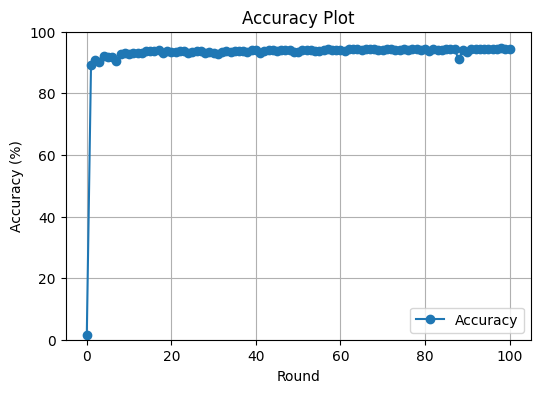

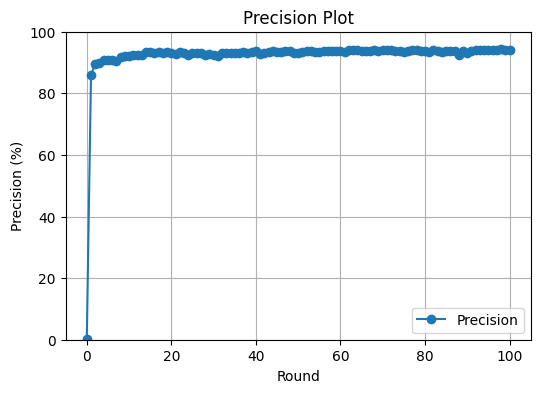

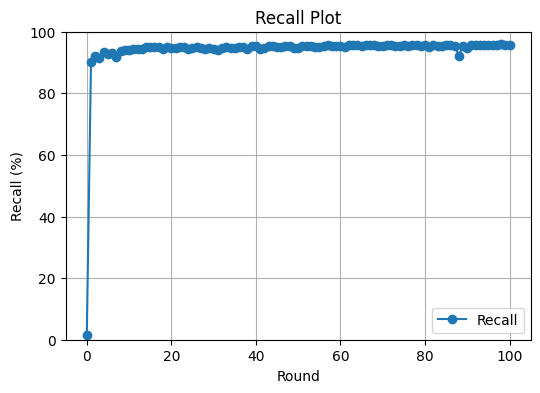

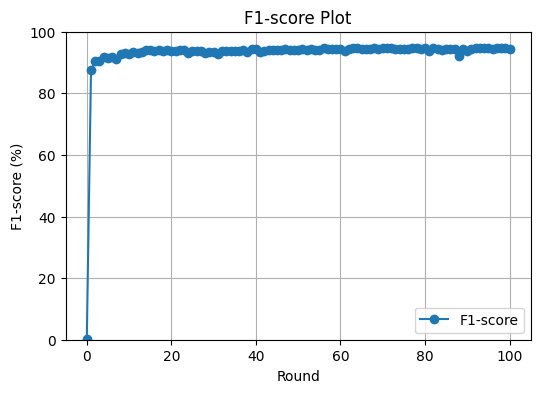

In [18]:
import matplotlib.pyplot as plt

print(f"{history.metrics_centralized = }")
print("8 Clients - Weighted - 1D-CNN+LSTM - 100 Rounds - 1 Epoch each")

global_accuracy_centralized = history.metrics_centralized["accuracy"]
global_precision_centralized = history.metrics_centralized["precision"]
global_recall_centralized = history.metrics_centralized["recall"]
global_fscore_centralized = history.metrics_centralized["fscore"]
rounds = [data[0] for data in global_accuracy_centralized]
accuracy = [100.0 * data[1] for data in global_accuracy_centralized]
precision = [100.0 * data[1] for data in global_precision_centralized]
recall = [100.0 * data[1] for data in global_recall_centralized]
fscore = [100.0 * data[1] for data in global_fscore_centralized]

# Plot Accuracy
plt.figure(figsize=(6, 4))
plt.plot(rounds, accuracy, label="Accuracy", marker='o')
plt.grid()
plt.ylabel("Accuracy (%)")
plt.xlabel("Round")
plt.ylim(0, 100)  # Set y-limits from 0 to 100
plt.legend()
plt.title("Accuracy Plot")
plt.show()

# Plot Precision
plt.figure(figsize=(6, 4))
plt.plot(rounds, precision, label="Precision", marker='o')
plt.grid()
plt.ylabel("Precision (%)")
plt.xlabel("Round")
plt.ylim(0, 100)  # Set y-limits from 0 to 100
plt.legend()
plt.title("Precision Plot")
plt.show()

# Plot Recall
plt.figure(figsize=(6, 4))
plt.plot(rounds, recall, label="Recall", marker='o')
plt.grid()
plt.ylabel("Recall (%)")
plt.xlabel("Round")
plt.ylim(0, 100)  # Set y-limits from 0 to 100
plt.legend()
plt.title("Recall Plot")
plt.show()

# Plot F1-score
plt.figure(figsize=(6, 4))
plt.plot(rounds, fscore, label="F1-score", marker='o')
plt.grid()
plt.ylabel("F1-score (%)")
plt.xlabel("Round")
plt.ylim(0, 100)  # Set y-limits from 0 to 100
plt.legend()
plt.title("F1-score Plot")
plt.show()


In [ ]:
import matplotlib.pyplot as plt

print(f"{history.metrics_centralized = }")
print("14 Clients - Weighted - 1D-CNN+LSTM - 100 Rounds - 1 Epoch each")

global_accuracy_centralized = history.metrics_centralized["accuracy"]
global_precision_centralized = history.metrics_centralized["precision"]
global_recall_centralized = history.metrics_centralized["recall"]
global_fscore_centralized = history.metrics_centralized["fscore"]
rounds = [data[0] for data in global_accuracy_centralized]
accuracy = [100.0 * data[1] for data in global_accuracy_centralized]
precision = [100.0 * data[1] for data in global_precision_centralized]
recall = [100.0 * data[1] for data in global_recall_centralized]
fscore = [100.0 * data[1] for data in global_fscore_centralized]

# Plot Accuracy
plt.figure(figsize=(6, 4))
plt.plot(rounds, accuracy, label="Accuracy", marker='o')
plt.grid()
plt.ylabel("Accuracy (%)")
plt.xlabel("Round")
plt.ylim(0, 100)  # Set y-limits from 0 to 100
plt.legend()
plt.title("Accuracy Plot")
plt.show()

# Plot Precision
plt.figure(figsize=(6, 4))
plt.plot(rounds, precision, label="Precision", marker='o')
plt.grid()
plt.ylabel("Precision (%)")
plt.xlabel("Round")
plt.ylim(0, 100)  # Set y-limits from 0 to 100
plt.legend()
plt.title("Precision Plot")
plt.show()

# Plot Recall
plt.figure(figsize=(6, 4))
plt.plot(rounds, recall, label="Recall", marker='o')
plt.grid()
plt.ylabel("Recall (%)")
plt.xlabel("Round")
plt.ylim(0, 100)  # Set y-limits from 0 to 100
plt.legend()
plt.title("Recall Plot")
plt.show()

# Plot F1-score
plt.figure(figsize=(6, 4))
plt.plot(rounds, fscore, label="F1-score", marker='o')
plt.grid()
plt.ylabel("F1-score (%)")
plt.xlabel("Round")
plt.ylim(0, 100)  # Set y-limits from 0 to 100
plt.legend()
plt.title("F1-score Plot")
plt.show()
